# Persistent Homology for High-Dimensional Data

In [1]:
# fundamental packages
import numpy as np
import matplotlib.pyplot as plt

# MDS, PCA, ...
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
import umap

# persistence diagrams
from ripser import ripser
from ripser import Rips
from persim import plot_diagrams

# computation of effective resistance
from sklearn.neighbors import kneighbors_graph
import networkx as nx
from scipy.spatial import distance
import scipy.sparse as sp
from scipy.spatial.distance import pdist, squareform

import warnings
warnings.filterwarnings("ignore")

## Introduction

Persistent homology is a method to discover topological features within point cloud data. Within this data, we construct a graph: two points are connected if and only if their distance is smaller than a parameter $2\epsilon$. At a specific $\epsilon$, enough points are connected to form a cycle-like structure which then can be detected by persistent homology. If $\epsilon$ is chosen too large, this cycle vanishes as the points on opposite sides are then connected. By a similar construction, even higher-dimensional topological features can be formed. Thus, by varying the scaling parameter $\epsilon$, one can study the appearance and disappearance of connected components, loops, voids or their higher-dimensional equivalents.

Using this method, one tries to differentiate between these topological features and surrounding noise by having a look at the "lifetime" of these features. The general interpretation is that noise forms a lot of cycles having a short "lifetime", whereas "true" cycles exist for a long time-span. Unfortunately, vanilla persistent homology based on the Euclidian distance is not robust against high-dimensional noise because the "true" topological features are blurred, leading persistent homology to detect "phantom cycles" within the noise. This phenomenon is known as the curse of dimension.

In the following, we start by giving a description of the curse of dimension and we give a short mathematical reasoning for its existence. An example shall illustrate the arising issues. Afterwards, we present two potential solutions to the curse of dimension. In a last chapter, we apply these solutions to different scenarios and compare their performance by inspecting their persistence diagrams and multi-dimensional scalings in two dimensions.

This work is based on work from the [pre-print](https://arxiv.org/pdf/2311.03087) by Damrich et al. 

## The curse of dimension

### Mathematical description

In a lot of use cases of persistent homology, the data is high-dimensional. For example, it can be used to identify cycles in genomic data from viruses where the dimension $d$ of the data equals the number of nucleotids of the virus' RNA. Thus, we have applications of persistent homology where $d \gg 1,000$.

It is often assumed that our data is sampled from a distribution where the points lie on a low-dimensional manifold, so the topological features to detect are of a much lower dimension than the actual data. This leads to the problem that actual distances between points on the low-dimensional manifold are overlaid by high-dimensional noise. 

To get more precise:
Suppose we have two vectors $v_1, v_2 \in \mathbb{R}^d$ which are sampled from a lower dimensional space $\mathbb{R}^s$ with euclidian distance $\delta$ in $\mathbb{R}^s$ and then overlaid by independent gaussian noise having variance $\sigma^2$. This means that we can split up $v_1$ and $v_2$ in a "real" part and a "noise" part:

$$
v_1 = (v_{1,r}^{(1)}, \dots, v_{1,r}^{(s)}, 0, \dots, 0) + (v_{1,n}^{(1)},v_{1,n}^{(2)}, \dots, v_{1,n}^{(d)}) \\
v_2 = (v_{2,r}^{(1)}, \dots, v_{2,r}^{(s)}, 0, \dots, 0) + (v_{2,n}^{(1)},v_{2,n}^{(2)}, \dots, v_{2,n}^{(d)})
$$

Then 

$$
\|v_1 - v_2\|_2^2 = \delta^2 + \sum_{i = 1}^d (v_{1,n}^{(i)} - v_{2,n}^{(i)})^2 + \sum_{j=1}^s (v_{1,r}^{(j)}-v_{2,r}^{(j)})(v_{1,n}^{(j)}-v_{2,n}^{(j)}).  
$$

As $v_{1,n}^{(i)}, v_{2,n}^{(i)} \sim \mathcal{N}(0, \sigma^2)$ for $i \in \{1, \dots, d\}$ and by the independence assumption, we know that $v_{1,n}^{(i)} - v_{2,n}^{(i)} \sim \mathcal{N}(0,2\sigma^2)$. Hence, $\sum_{i = 1}^d (v_{1,n}^{(i)} - v_{2,n}^{(i)})^2 \sim \Gamma(\frac{d}{2}, 4\sigma^2)$ (Gamma-distribution) and the expected squared distance between $v_1$ and $v_2$ in $\mathbb{R}^d$ is given by 

$$
\begin{align*}
\mathbf{E}[\|v_1 - v_2\|_2^2] &= \delta^2 + \mathbf{E}\left[\sum_{i = 1}^d (v_1^{(i)} - v_2^{(i)})^2\right] + \mathbf{E}\left[\sum_{j=1}^s (v_{1r}^{(j)}-v_{2r}^{(j)})(v_{1n}^{(j)}-v_{2n}^{(j)})\right]\\
&= \delta^2 + 2\sigma^2 d + \sum_{j=1}^s(v_{1r}^{(j)}-v_{2r}^{(j)})\underbrace{\mathbf{E}\left[(v_{1n}^{(j)}-v_{2n}^{(j)})\right]}_{=0}\\
&= \delta^2 + 2\sigma^2 d.
\end{align*}
$$

Hence, the squared distance linearly scales with the dimension $d$ and the variance $\sigma^2$.
Plugging in some numbers for a quick example: Let us assume we have a variance of $\sigma^2=0.2$. Two points in $\mathbb{R}^{1000}$, which actually come from $\mathbb{R}^2$ with a distance of $1$ would have an expected euclidian distance of $\approx 20$. If they had a real distance of $5$, their expected distance in $\mathbb{R}^{1000}$ would only be $\approx 20.61$. Points that are $5$ times further in $\mathbb{R}^2$ away would only be a tiny bit further away of each other in $\mathbb{R}^{1000}$. 

As a consequence, topological features which are present in $\mathbb{R}^s$ become blurred as the real distances which make up these features are all assimilated by the high-dimensional noise, leading to massive problems for vanilla persistence homology to detect these features.

### Example: 

In the following, this effect is demonstrated by an example. We embed $N = 1000$ data points which are uniformly sampled on the unit circle from $\mathbb{R}^2$ into $\mathbb{R}^{50}$ via a random orthogonal matrix $V \in \mathbb{R}^{50\times 2}$. We add Gaussian noise sampled from $\mathcal{N}(\mathbf{0}, 0.2^2 \mathbf{I_{50}})$. 

To see the effects of the embedding in the higher dimensional space on persistent homology, we will have a look at the persistence diagrams. In these persistence diagrams, each point represents the homology class of a cycle which is "born" at a specific $\epsilon$ (depicted by the value on the $x$-axis) and "dies" at a higher $\epsilon$, which is the corresponding $y$-coordinate. It follows directly that all of these points are in the upper left diagonal as birth times are smaller than death times. The persistence ($\hat{=}$ lifetime of a cycle) is then given by the distance to the diagonal. For each diagram, we compute a so-called persistence score $p$ which measures how "outstanding" the cycle with the highest persistence is. We define $p$ as 

$$
p := \frac{\frac{1}{\sqrt{2}}((d_1-b_1) - (d_2-b_2))}{\frac{1}{2}(d_1+b_1)} = \sqrt{2} \frac{(d_1-b_1)-(d_2-b_2)}{d_1+b_1}
$$,

where $b_1, d_1$ denote the birth and death times of the most persistent cycle respectively and $b_2,d_2$ the birth and death times of the second most persistent cycle. A low persistence score $(\approx 0)$ indicates that no "true" cycle could be detected. $p$ is especially well suitable when there is only one true "hole" in the data without the noise. 

In [2]:
# dimension of embedding space
d = 100
# sample size
N = 1000
# standard devation of noise
sd = 0.3

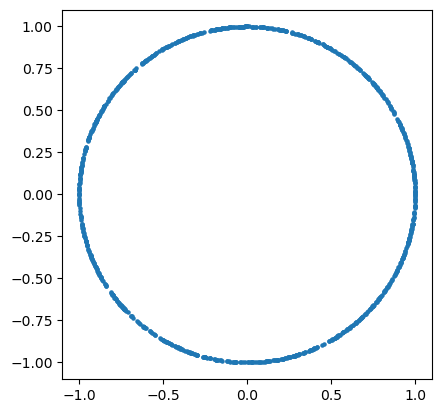

In [3]:
#  sample angles randomly by uniform distribution
angles = np.random.uniform(0, 2*np.pi, N)
data = np.array([np.cos(angles), np.sin(angles)])

plt.scatter(data[0,:], data[1,:], s=5)
plt.gca().set_aspect('equal')
plt.show()

In [5]:
# create orthogonal matrix
orth_matrix = rand_orth_matrix(d, 2)
# embed data in higher-dimensional space
data_hd = orth_matrix @ data
# create noise
noise = np.random.multivariate_normal(np.repeat(0,d), sd**2 * np.identity(d), N).T
# add noise
noised_data = data_hd + noise
noised_data = noised_data.T

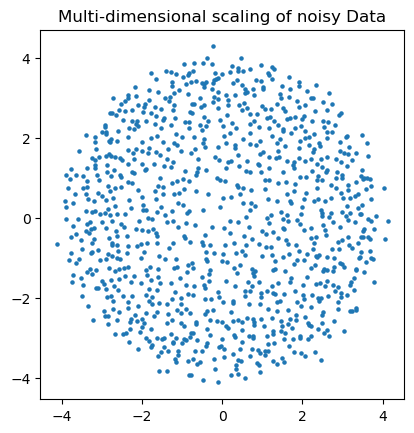

In [6]:
# create multi-dimensional scaling of noisy data to see effects of noise on ring structure
mds = MDS(n_components = 2)
data_mds = mds.fit_transform(noised_data)

plt.scatter(data_mds[:, 0], data_mds[:, 1], s = 5)
plt.gca().set_aspect('equal')
plt.title("Multi-dimensional scaling of noisy Data")
plt.show()

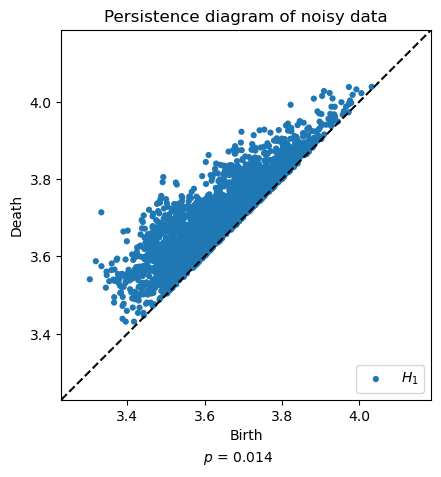

In [7]:
# create persistence diagram
diagrams = ripser(noised_data)['dgms']

# compute persistence score
pers_score = persistence_score(diagrams)
 

plot_diagrams(diagrams, plot_only = [1])
plt.title("Persistence diagram of noisy data")
plt.figtext(0.5, -0.02, rf"$p$ = {pers_score}", ha = "center")
plt.show()

Clearly, the noise significantly blurrs the data. In the 2-dimensional scaling, one can hardly recognize the original ring structure. As a consequence, persistent homology could not detect cycle with a long lifetime, leading to a low persistence score of almost $0$.

## Solutions

### Solution 1: Persistent homology on 2-d embeddings

Without noise, the 2d-PCA projection of the high-dimensional data would be equal to the original cycle, as the embedding via an orthogonal matrix is a linear map which does not distort the data. Thus, as long as the noise is not too high, the ring structure of the noisy data can be recovered by a usual PCA.

In our example, the persistence score can be increased  from almost $0$ to more than $0.5$ by running persistent homology on the PCA data.

In [8]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(noised_data)

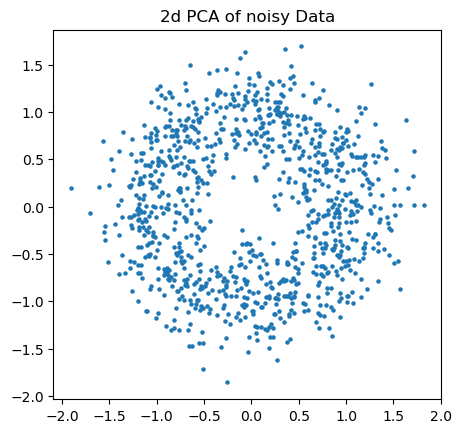

In [9]:
plt.scatter(data_pca[:, 0], data_pca[:, 1], s = 5)
plt.gca().set_aspect('equal')
plt.title("2d PCA of noisy Data")
plt.show()

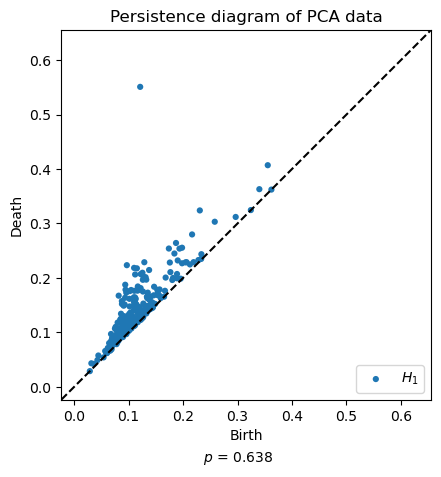

In [10]:
diagrams_pca = ripser(data_pca)['dgms']

pers_score = persistence_score(diagrams_pca)

plot_diagrams(diagrams_pca, plot_only = [1])
plt.title("Persistence diagram of PCA data")
plt.figtext(0.5, -0.02, rf"$p$ = {pers_score}", ha = "center")
plt.show()

The drawback of this approach is obvious: If the cycle is distorted in a non-linear way, PCA is technically not able to recover the structure correctly. Thus, the usage of more sophisticated algorithms like t-SNE or UMAP is required. 

Exemplary, we show how good UMAP can reconstruct the ring in contrast to PCA.

In [ ]:
# make rough grid search to find best hyperparameters
n_neighbors = np.array([2, 5, 10, 15, 20, 50])
min_dist = np.array([0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5])

neighs, dists, pers_score = umap_hyperparameter(n_neighbors, min_dist)

In [59]:
umap_model = umap.UMAP(n_neighbors=int(neighs), min_dist=dists)
data_umap = umap_model.fit_transform(noised_data)

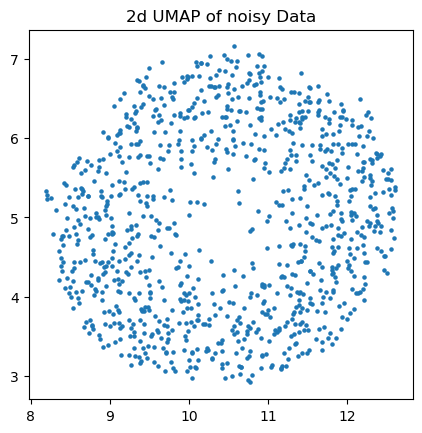

In [60]:
plt.scatter(data_umap[:, 0], data_umap[:, 1], s = 5)
plt.gca().set_aspect('equal')
plt.title("2d UMAP of noisy Data")

plt.show()

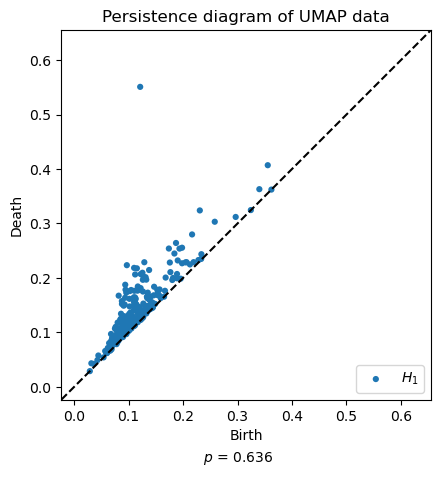

In [61]:
diagrams_umap = ripser(data_umap)['dgms']

pers_score = persistence_score(diagrams_umap)
plot_diagrams(diagrams_pca, plot_only = [1])
plt.title("Persistence diagram of UMAP data")
plt.figtext(0.5, -0.02, rf"$p$ = {pers_score}", ha = "center")
plt.show()

By using UMAP, the results can be improved. We obtain a persistence score which is significantly higher than the persistence score on PCA data.

### Solution 2: Using random-walk based distances

In order to compute persistence homology, ripser only uses the distance matrix. Thus, another approach might be to introduce a new distance metric $D$. In practice, it turns out that distance measures which are based on random walks perform reasonably well to detect the hole in a noisy ring. 

These random walks are performed on the $k$-nearest neighbor graph of the data: Each vertex (each data point) is connected to its $k$ closest vertices ("closest" is measured via the usual euclidian distance). Suppose we want to reach vertex $v_j$ from vertex $v_i$ and we move randomly along its edges. If $v_i$ and $v_j$ are both in the same dense are, there are a lot of paths connecting these points, making it more likely to reach $v_j$ from $v_i$ in a short amount of time. If there would only be few paths connecting $v_i$ and $v_j$, the random walk would take a long time to reach $v_j$ as it would be unlikely to cross sparsely connected regions. Applying this heuristic to the noisy ring, this means that it is unlikely to cross the ring through the sparsely connected centre region as most of the paths lie most frequently along the contour of the ring. On this basis, we can define $D(v_i, v_j)$ to be the average time the random walk needs to reach $v_j$ starting in $v_i$. Intuitively, the ring is stretched and large distances are enhanced by using $D$.

The actual distances we use are the effective resistance $d^{\text{eff}}_{ij}$ and the diffusion distance $d^{\text{diff}}_{ij}$ between  $v_i$ and $v_j$. Both of them differ quite a bit from the heuristic explaination above, but at the core they both follow the same principle.

In [75]:
# create distance matrix from data
dist_matrix = distance_matrix_diffusion(noised_data, 15)

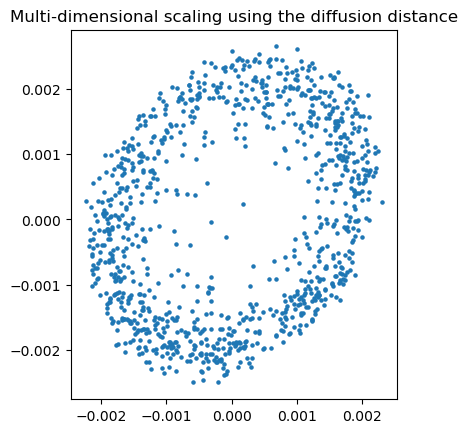

In [77]:
# create multi-dimensional scaling using the distance matrix with the diffusion distance
mds = MDS(n_components = 2, dissimilarity='precomputed')
data_mds_diff = mds.fit_transform(dist_matrix)

plt.scatter(data_mds_diff[:, 0], data_mds_diff[:, 1], s = 5)
plt.gca().set_aspect('equal')
plt.title("Multi-dimensional scaling using the diffusion distance")
plt.show()

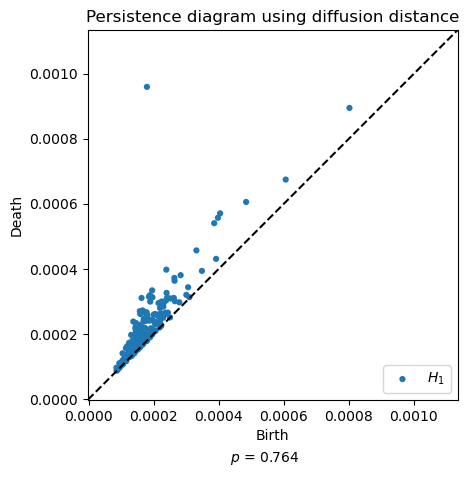

In [76]:
diagrams_diff = ripser(dist_matrix, distance_matrix = True)['dgms']

pers_score = persistence_score(diagrams_diff)
plot_diagrams(diagrams_diff, plot_only = [1])
plt.title("Persistence diagram using diffusion distance")
plt.figtext(0.5, -0.02, rf"$p$ = {pers_score}", ha = "center")
plt.show()

Clearly, the persistence score is higher than when we use the usual euclidian distance. But in this example, persistent homology works even better on the PCA or UMAP projections.

## Results

Overview over functions:
- create_figs_ph
- create_figs_pca
- create_figs_ph_pca
- create_figs_umap
- create_figs_ph_umap
- create_figs_rwd
- create_figs_ph_rwd

In [78]:
# dimension of large embedding space
ds = np.array([3, 10, 20, 50, 100, 1000])

# number of data points
N = 1000

# standard deviation of the noise
sds = np.array([0.05, 0.1, 0.2, 0.3, 0.5])

In [83]:
#  sample angles randomly by uniform distribution
angles = np.random.uniform(0, 2*np.pi, N)
data = np.array([np.cos(angles), np.sin(angles)]).T

### Persistent homology of noisy data

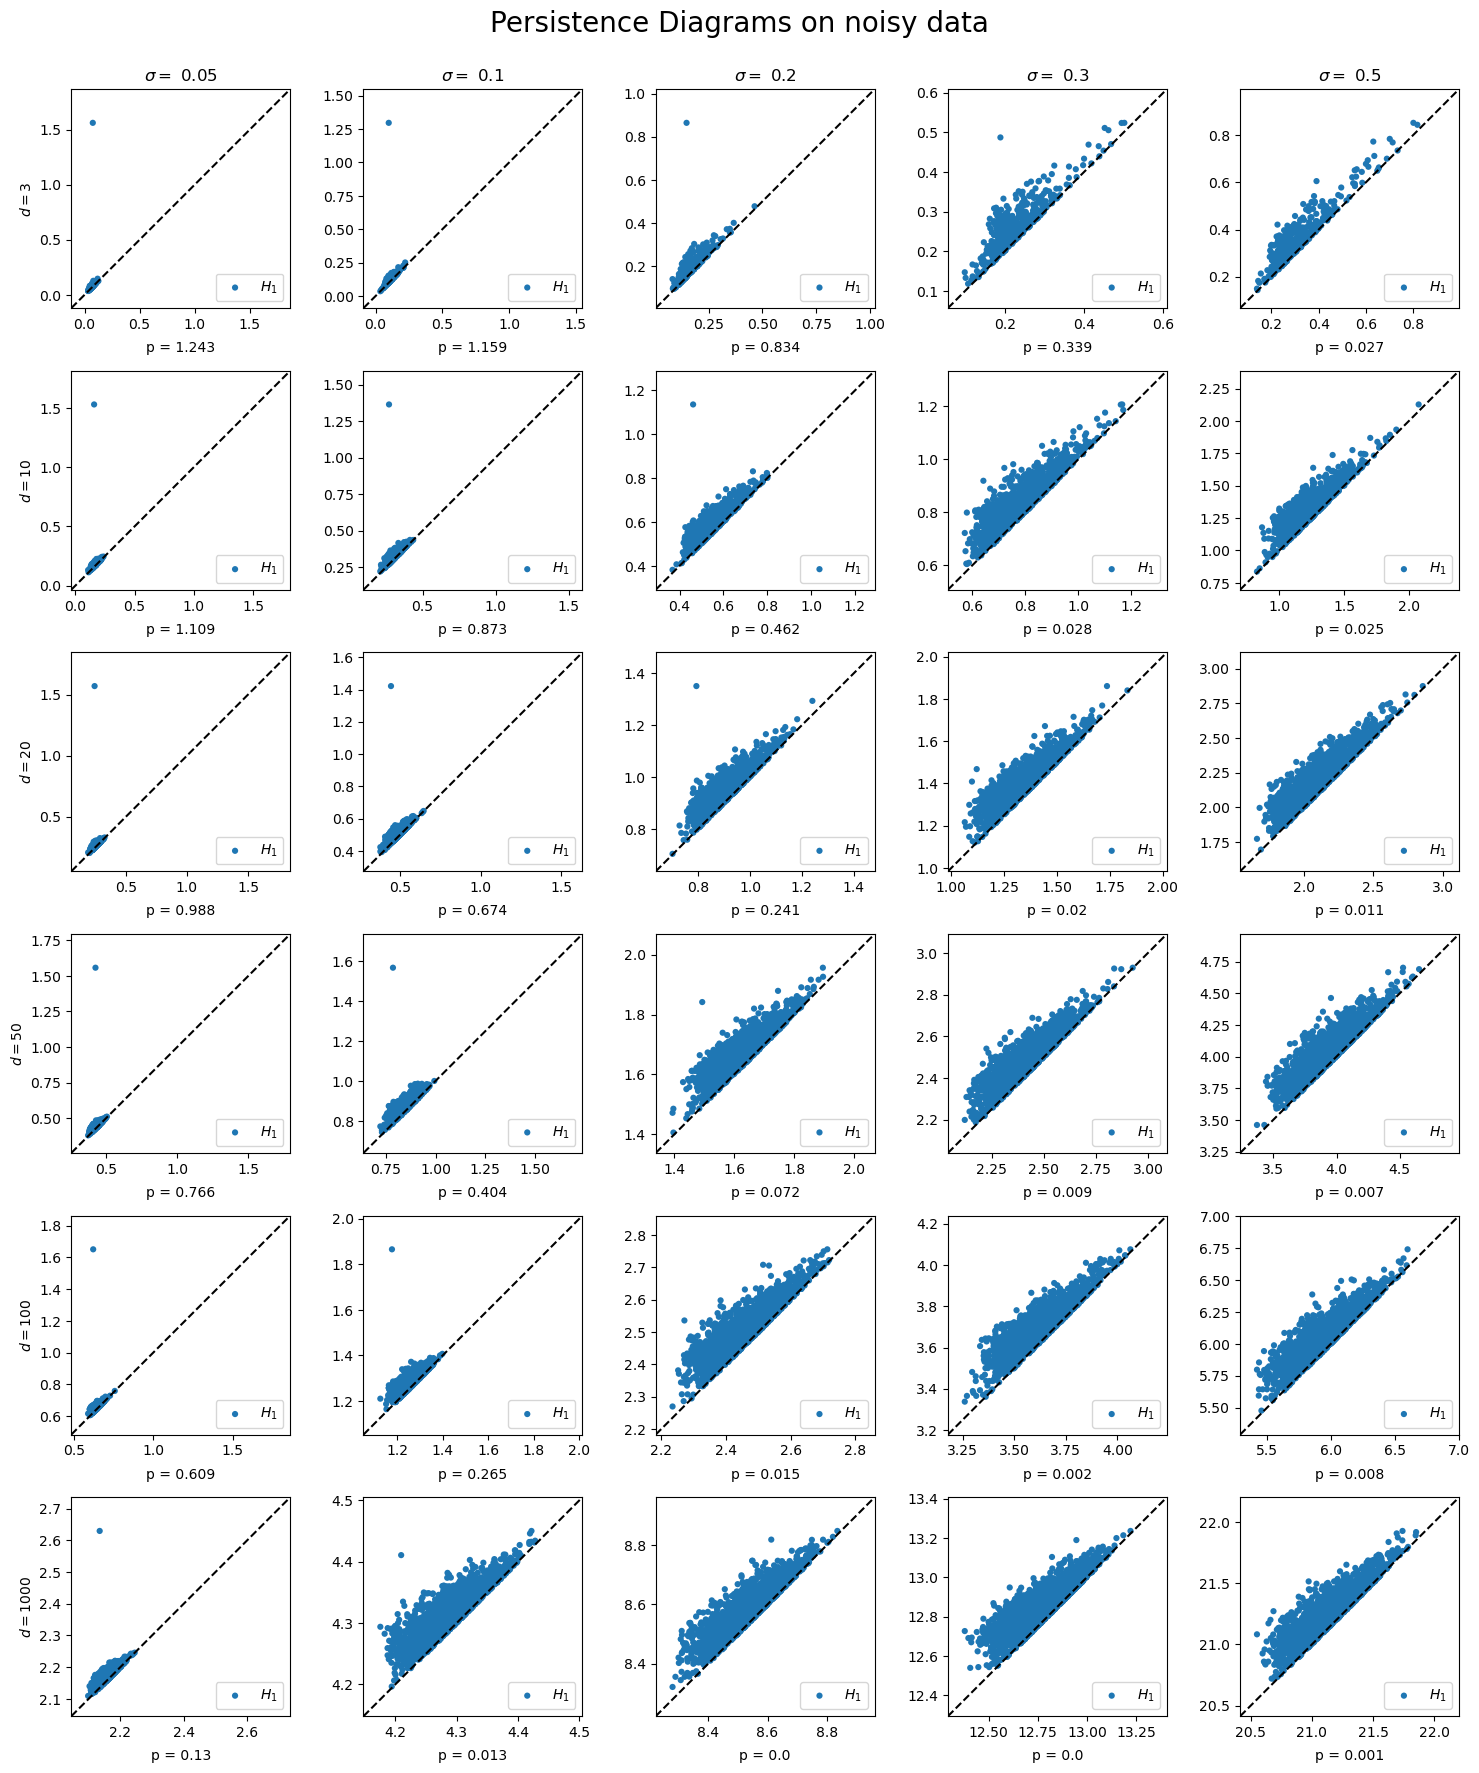

In [84]:
create_figs_ph(ds, sds, data, 1)

### PCA 
#### Plots

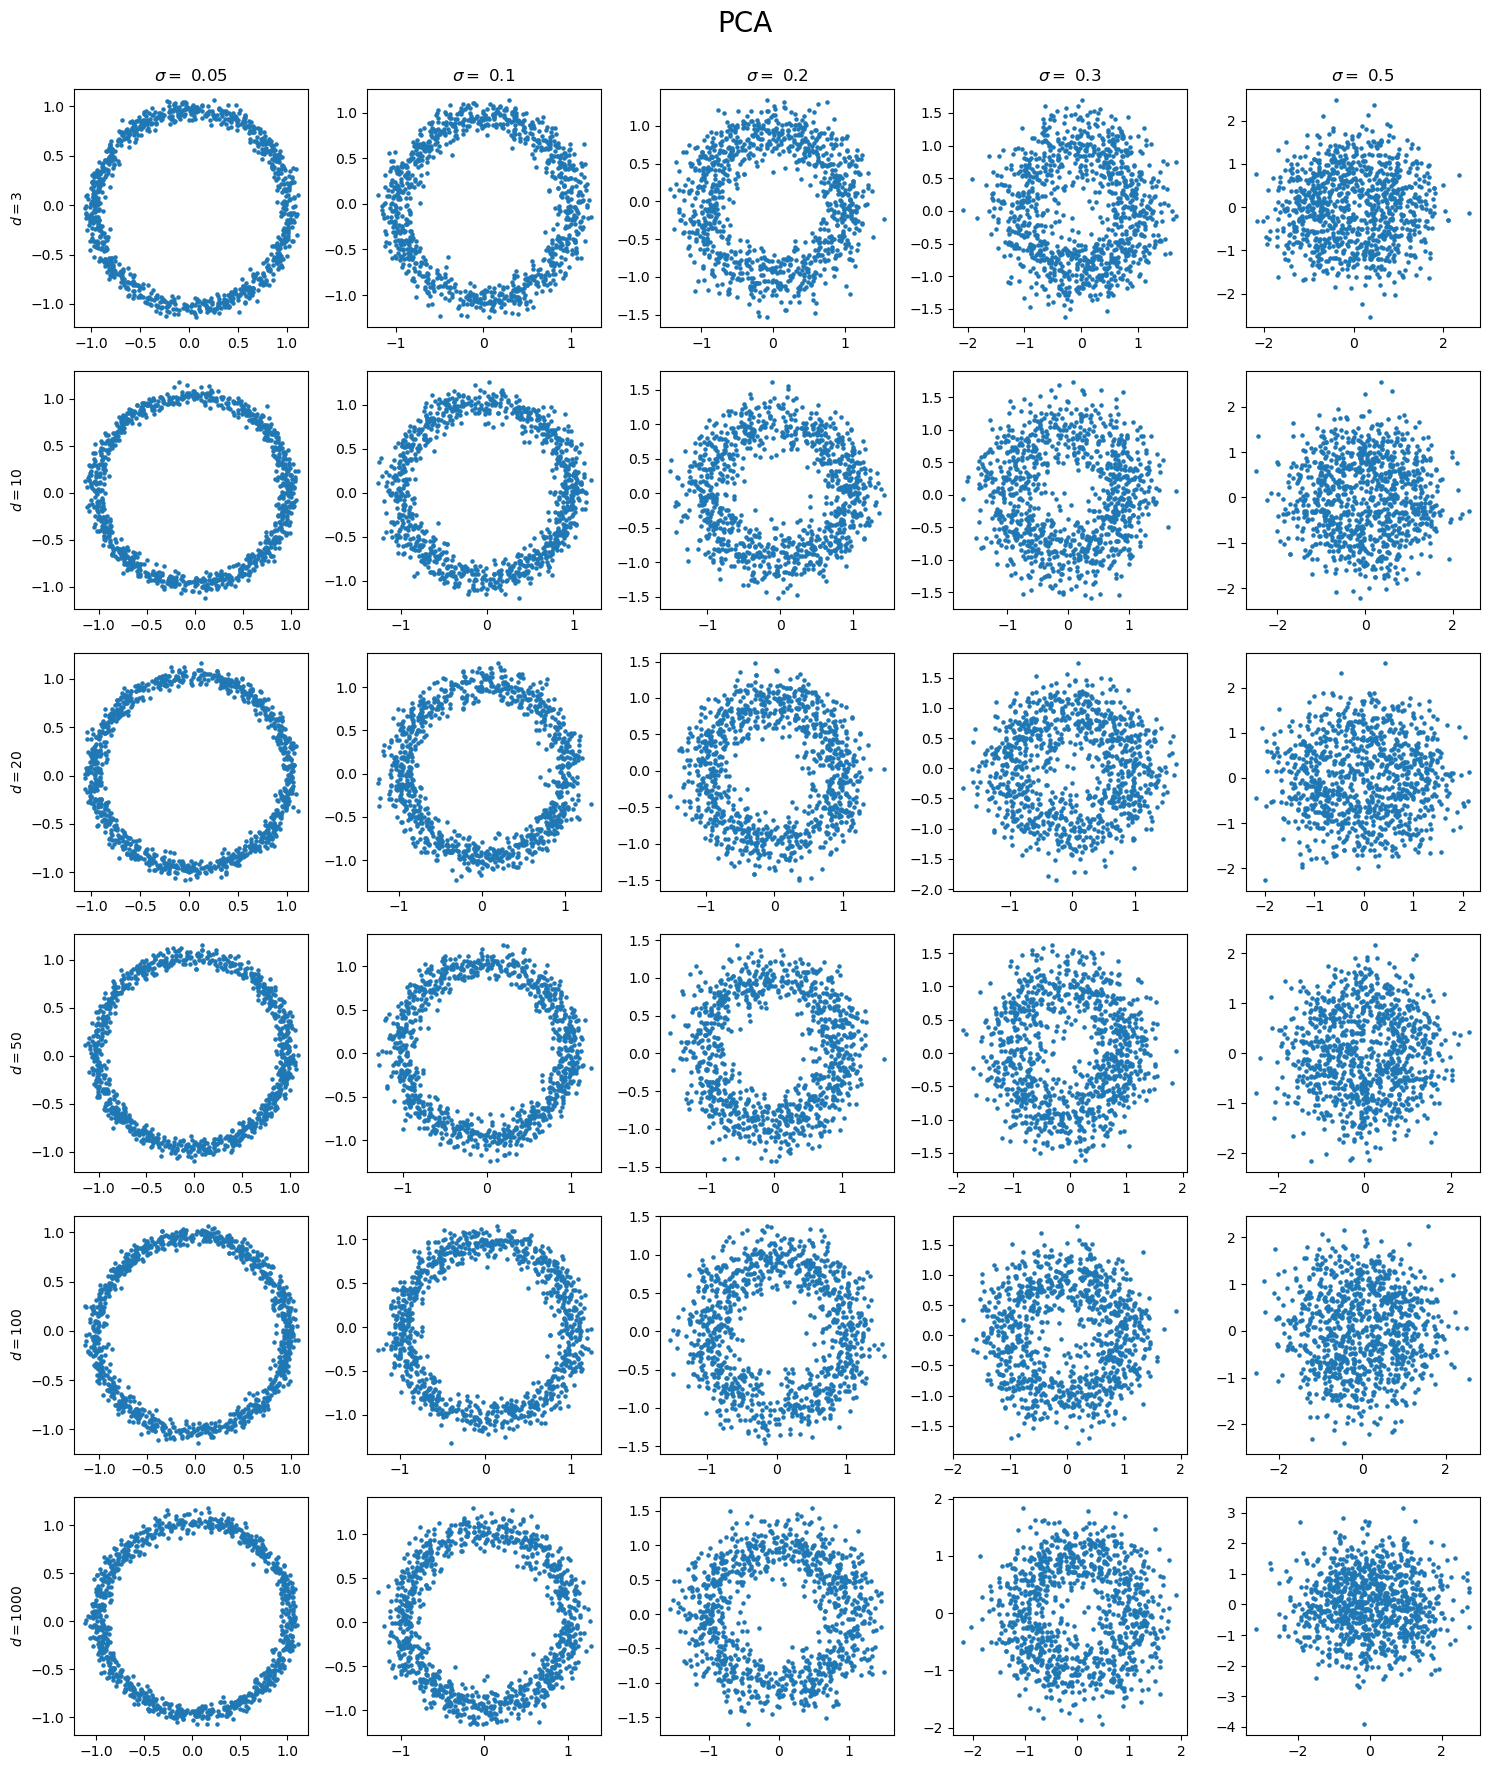

In [85]:
create_figs_pca(ds, sds, data, 2)

#### Persistence diagrams 

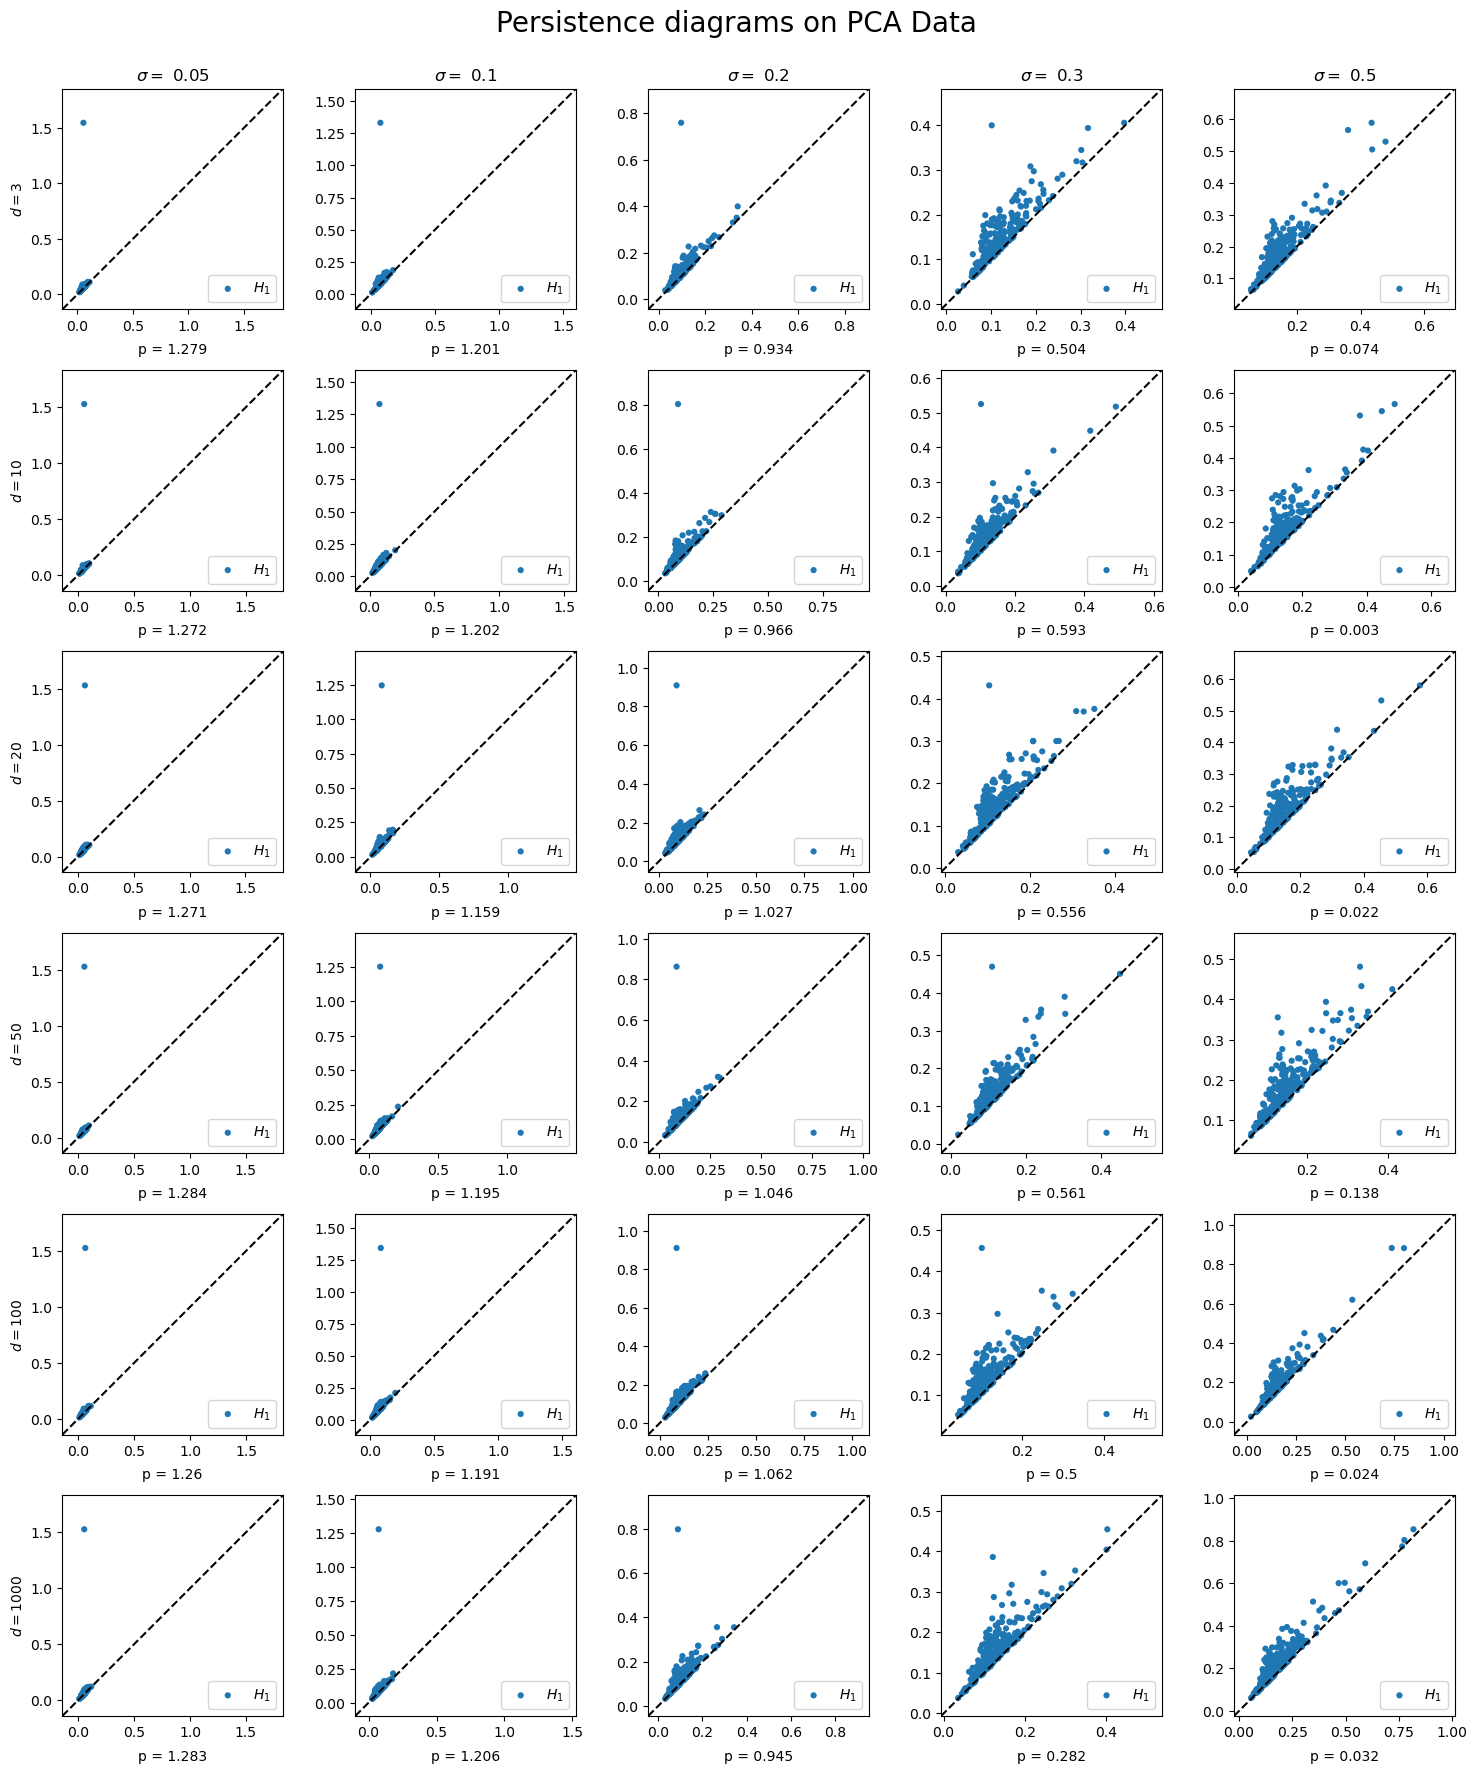

In [87]:
create_figs_ph_pca(ds, sds, data, 2, 1)

### UMAP 
#### Plots

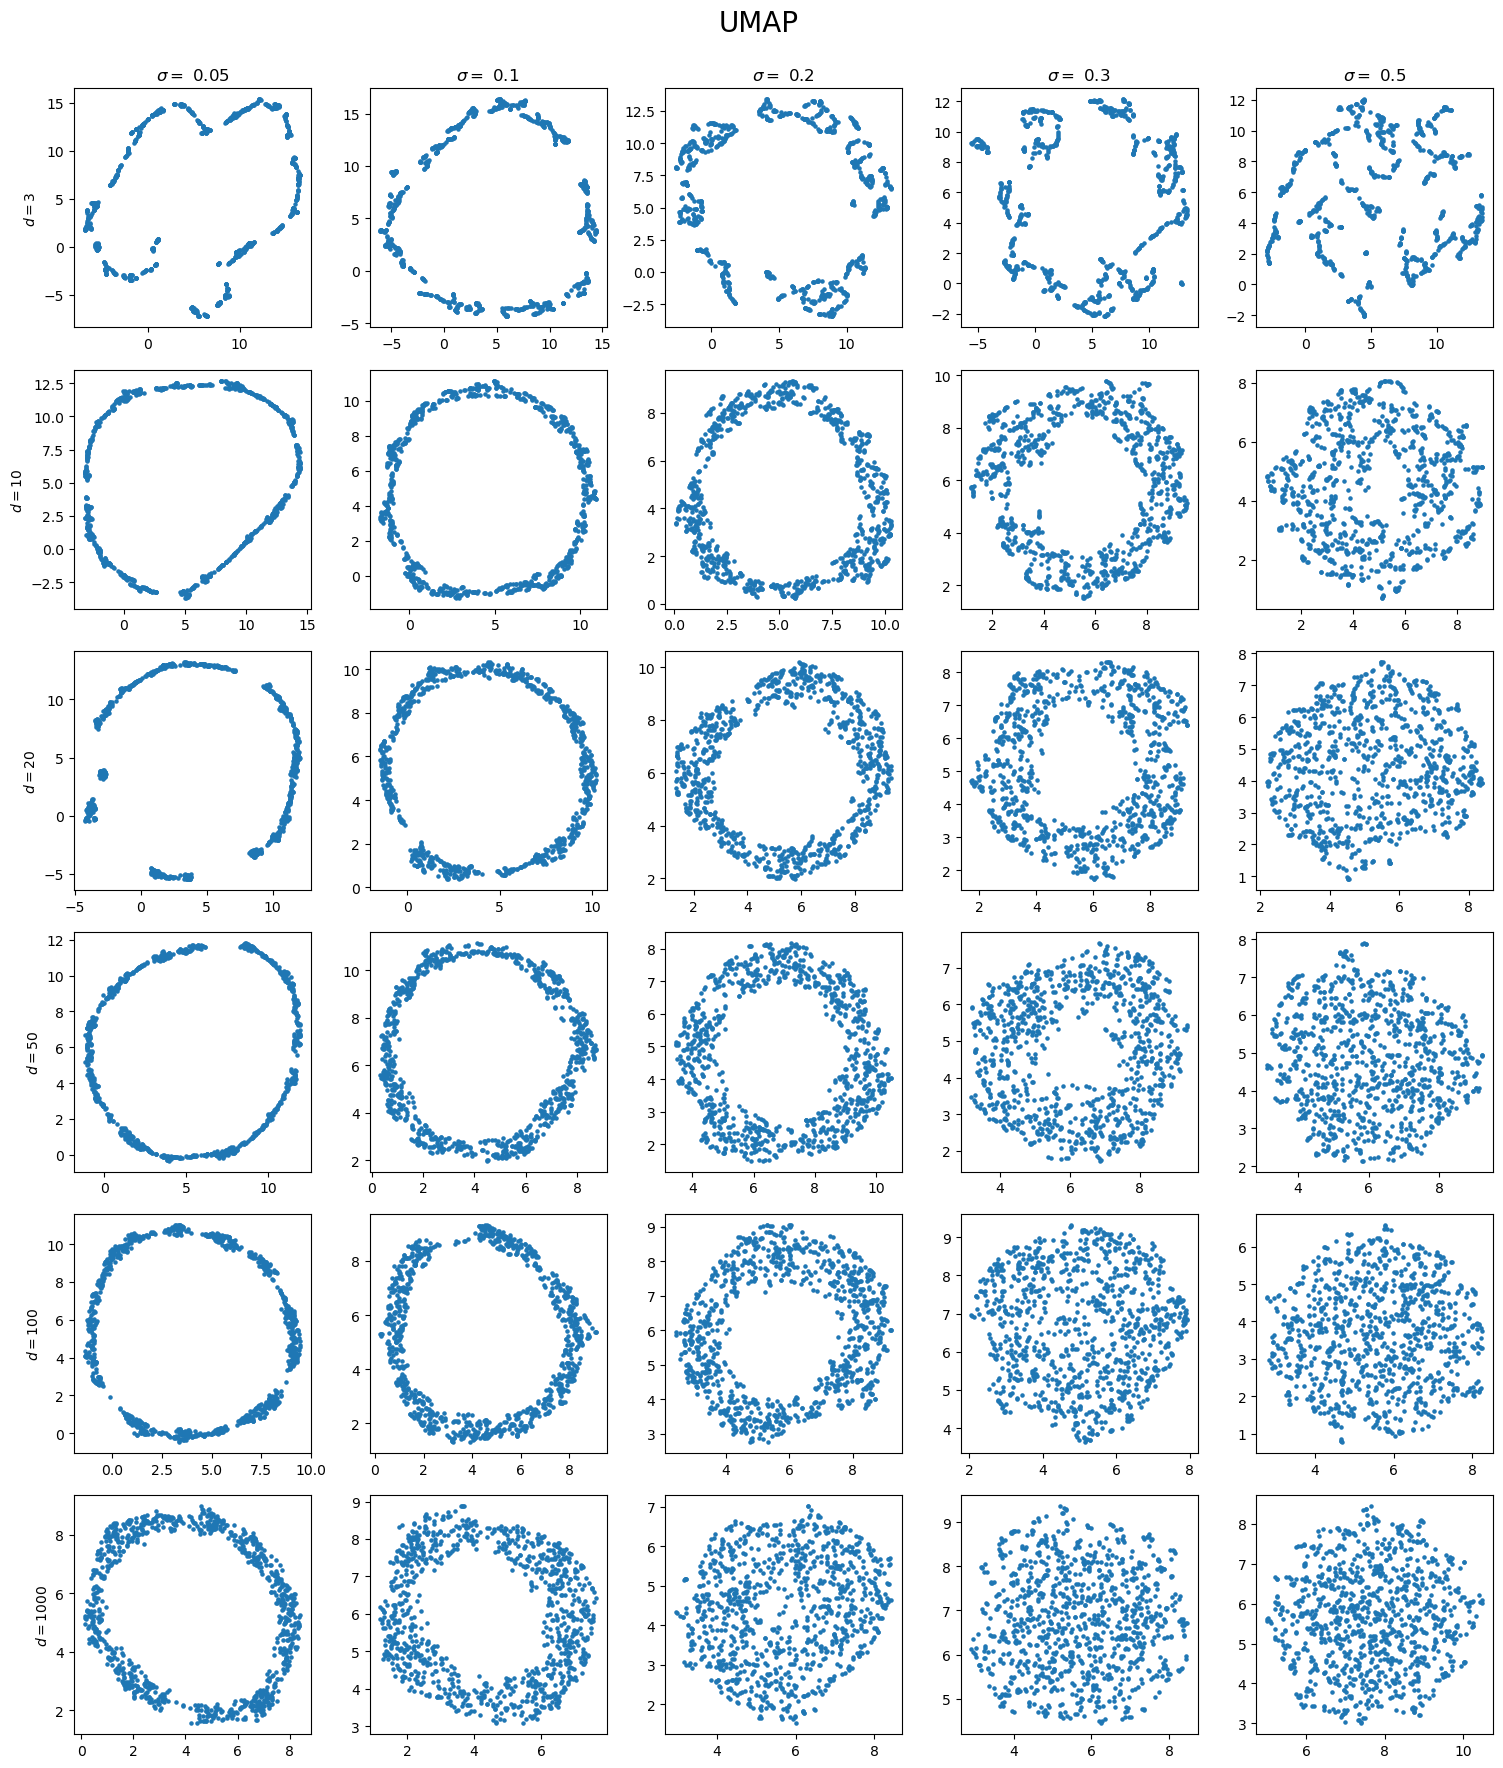

In [88]:
create_figs_umap(ds, sds, data, 5, 0.02)

#### Persistence diagrams

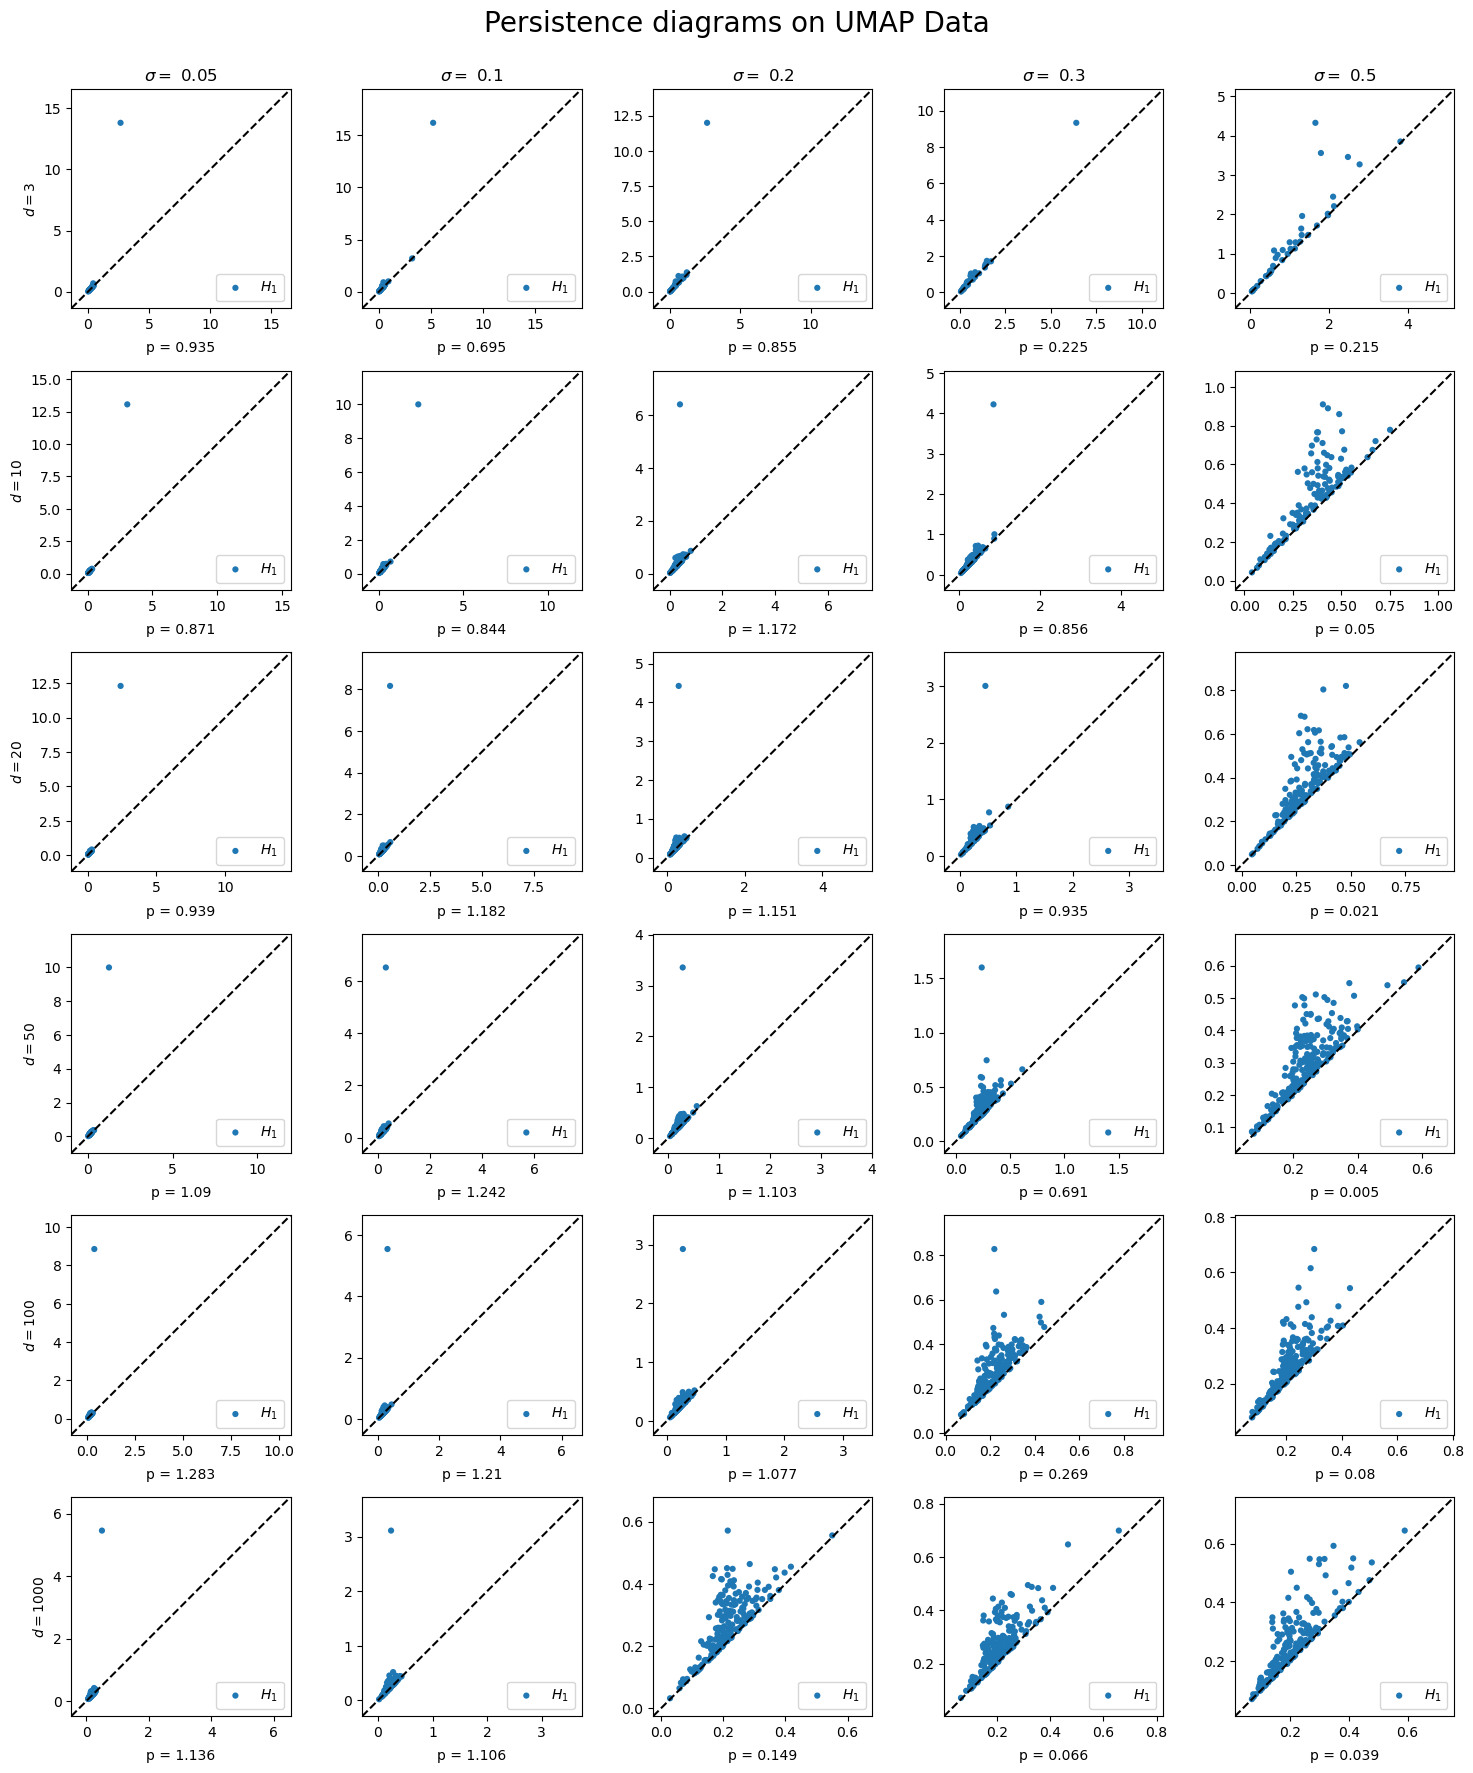

In [89]:
create_figs_ph_umap(ds, sds, data, 5, 0.02, 1)

### Random-walk-based distances
#### MDS plots

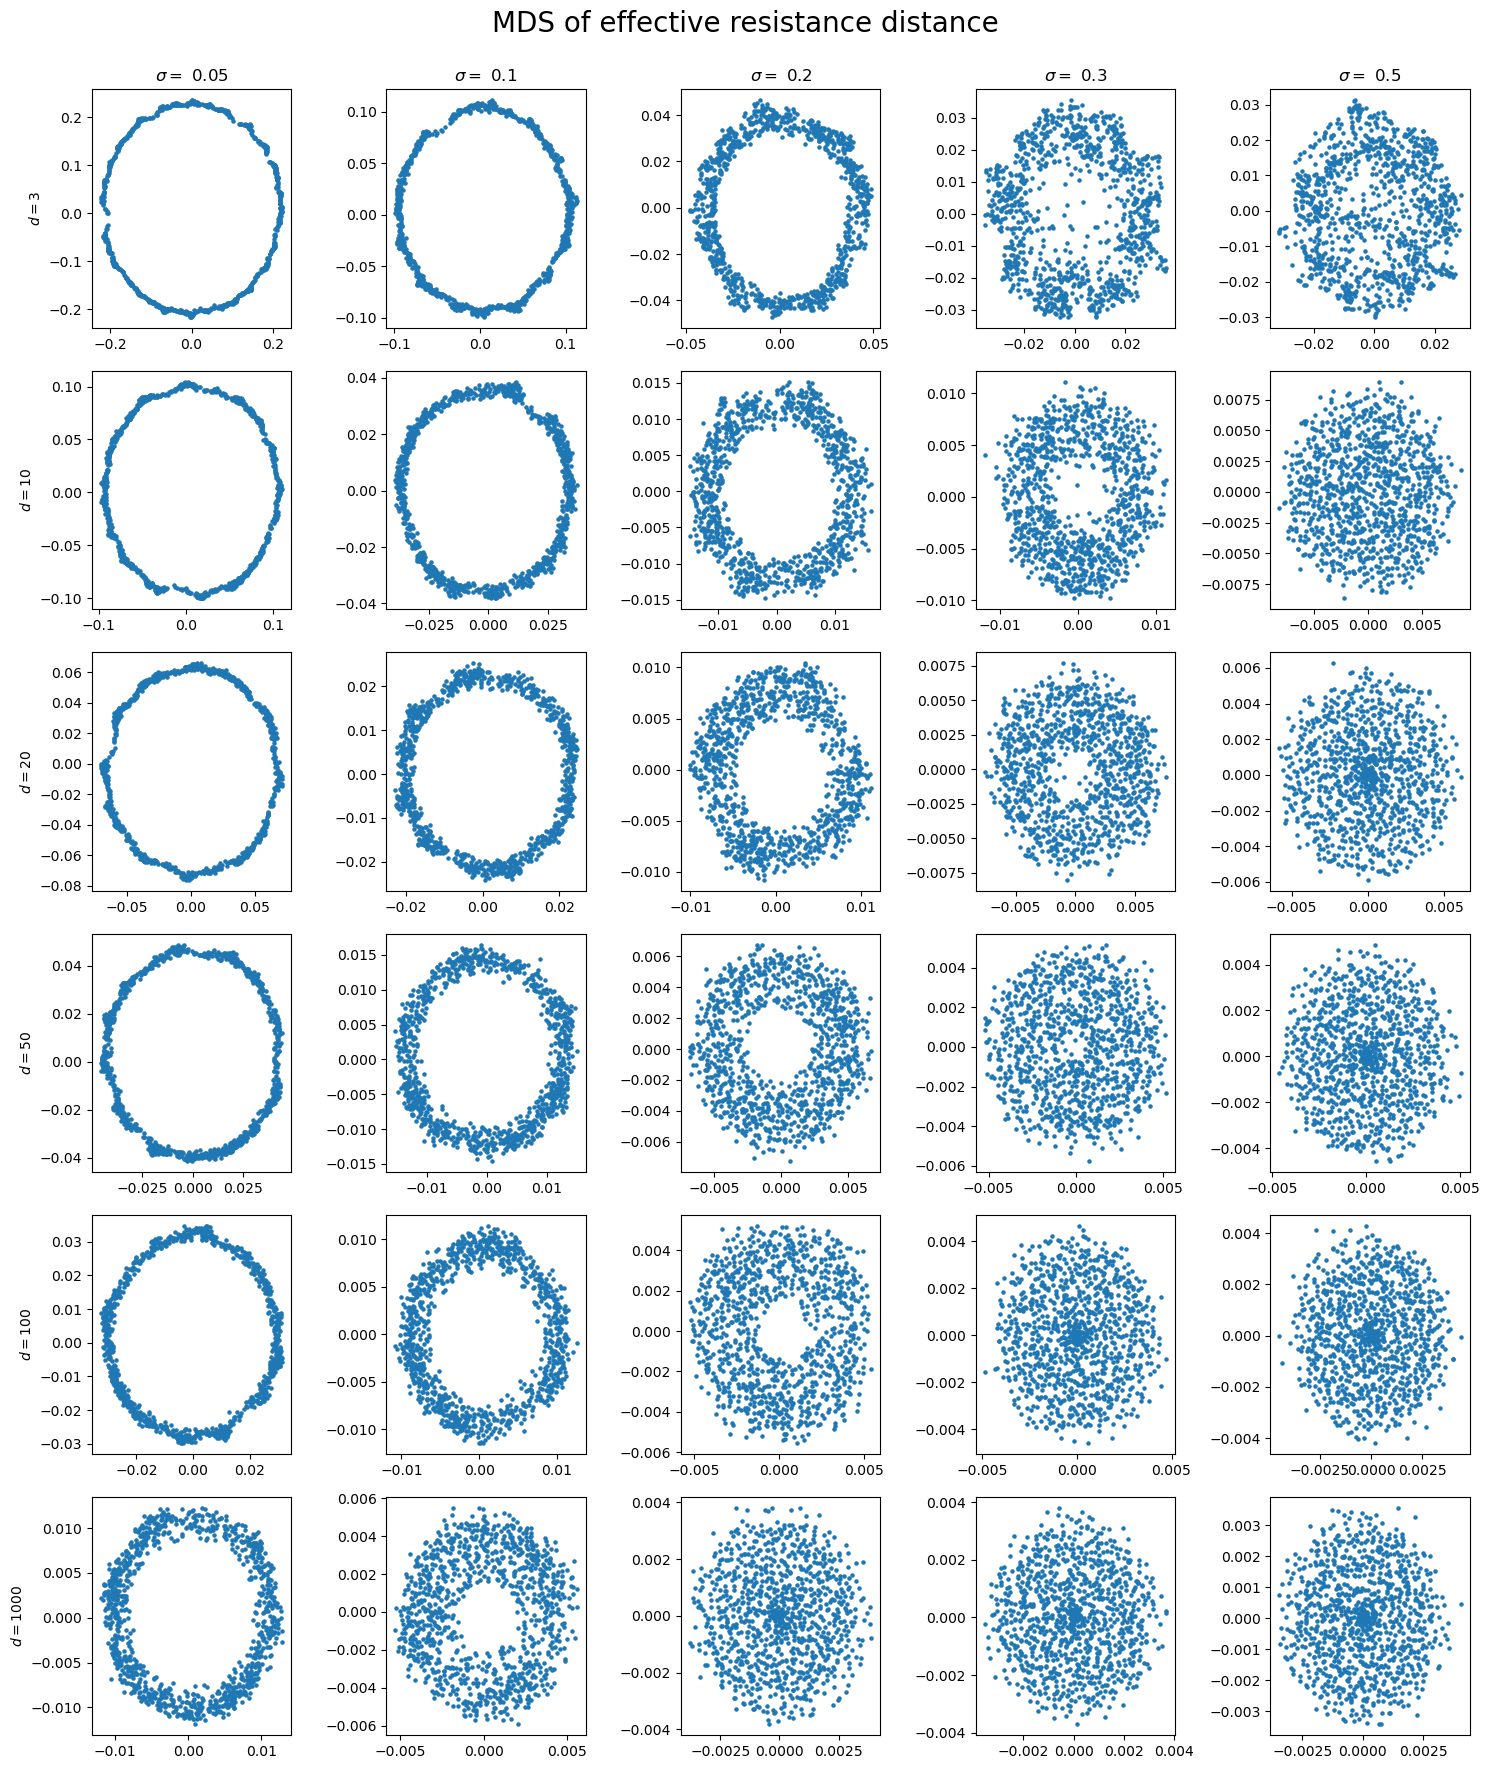

In [98]:
create_figs_rwd(ds, sds, data, "eff_res", 15) 

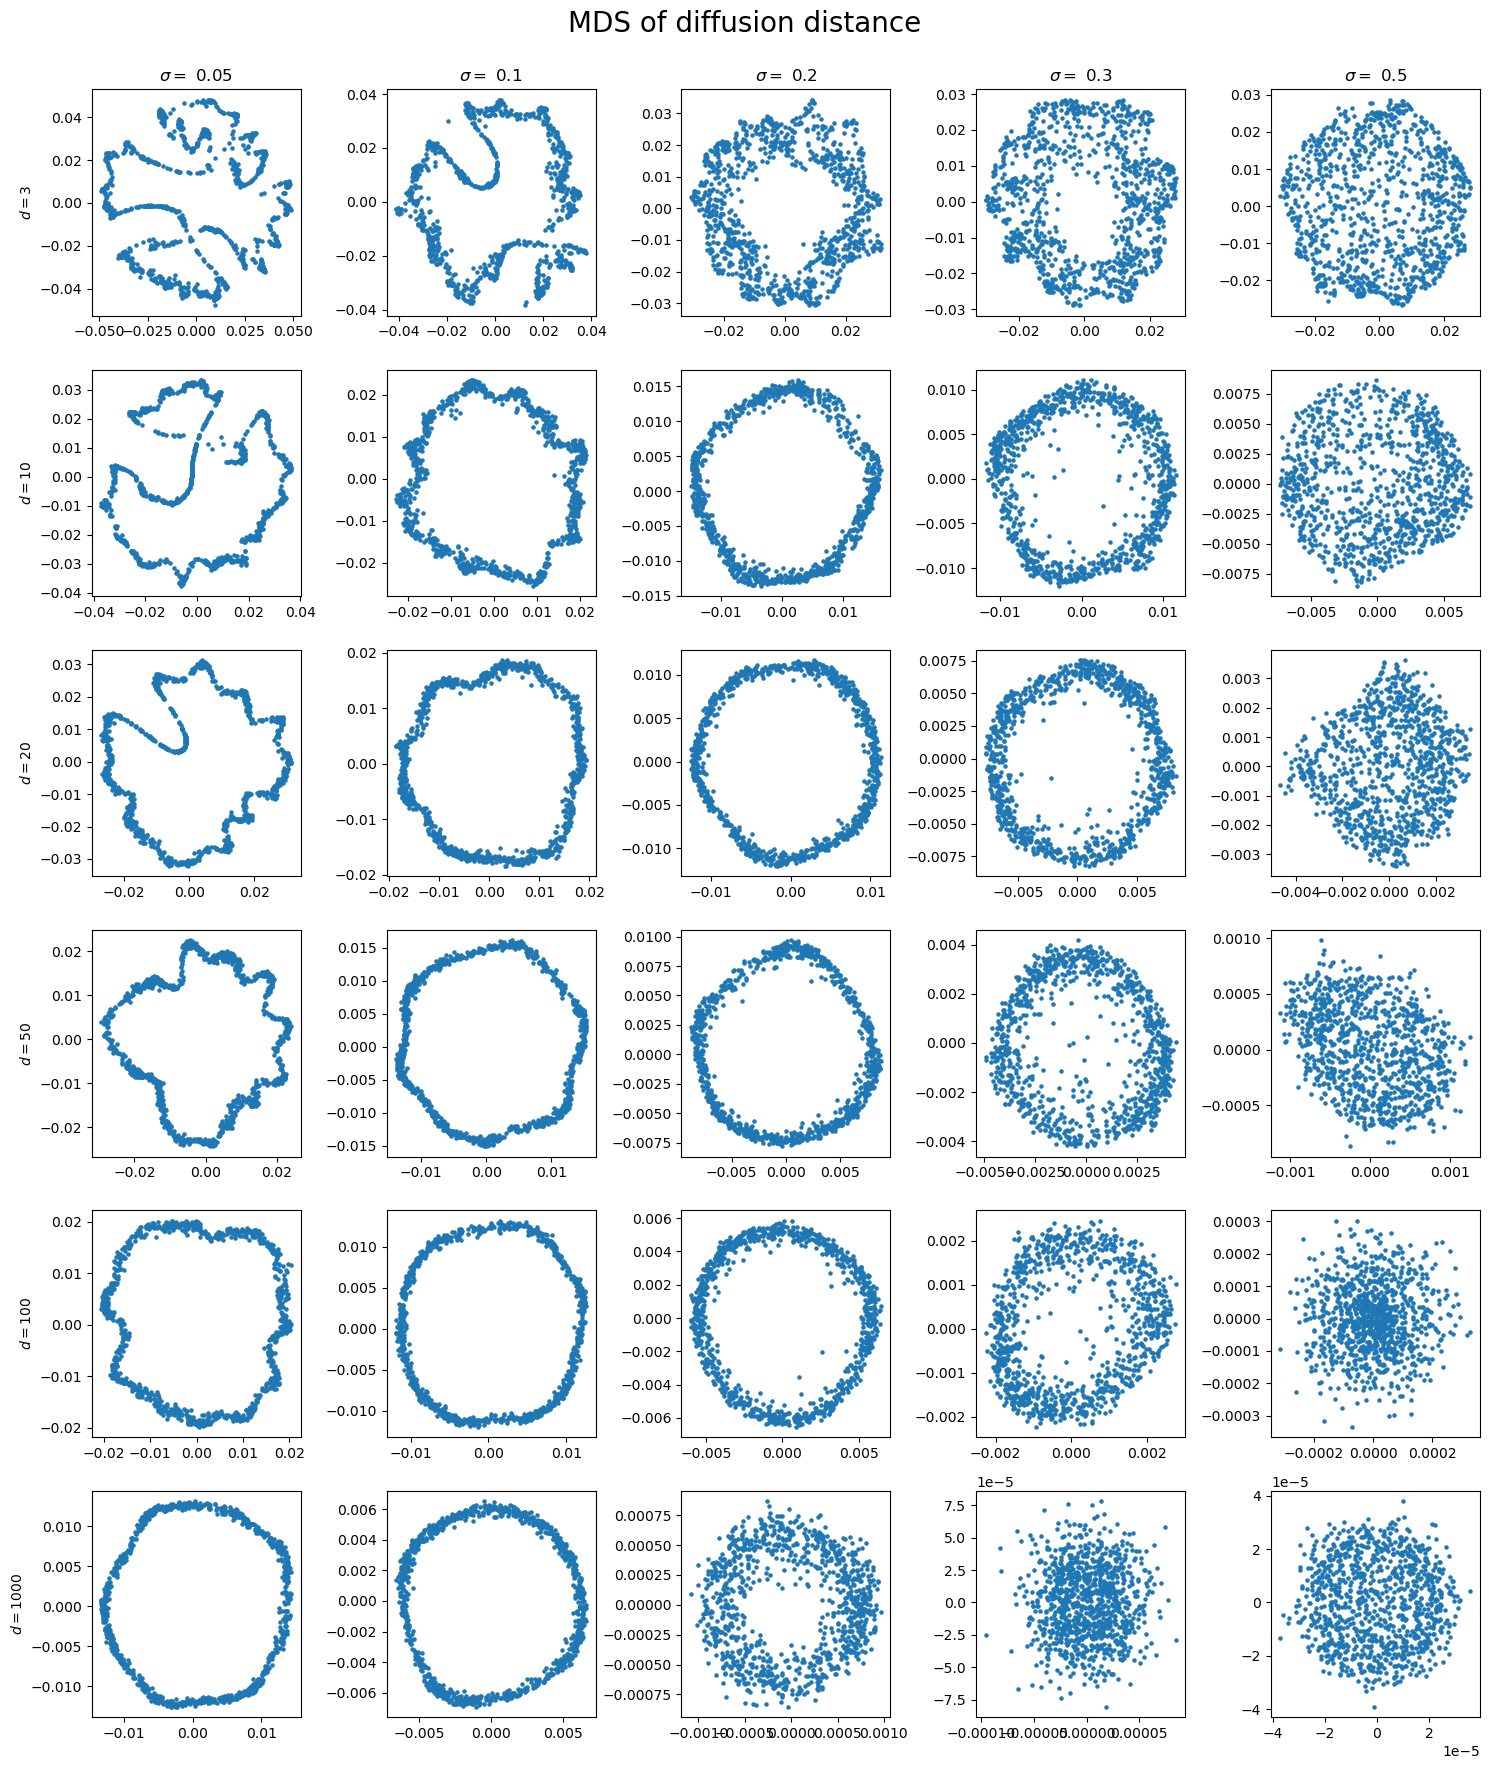

In [99]:
create_figs_rwd(ds, sds, data, "diffusion", 15, 8) 

#### Persistence diagrams 

IndexError: index 0 is out of bounds for axis 0 with size 0

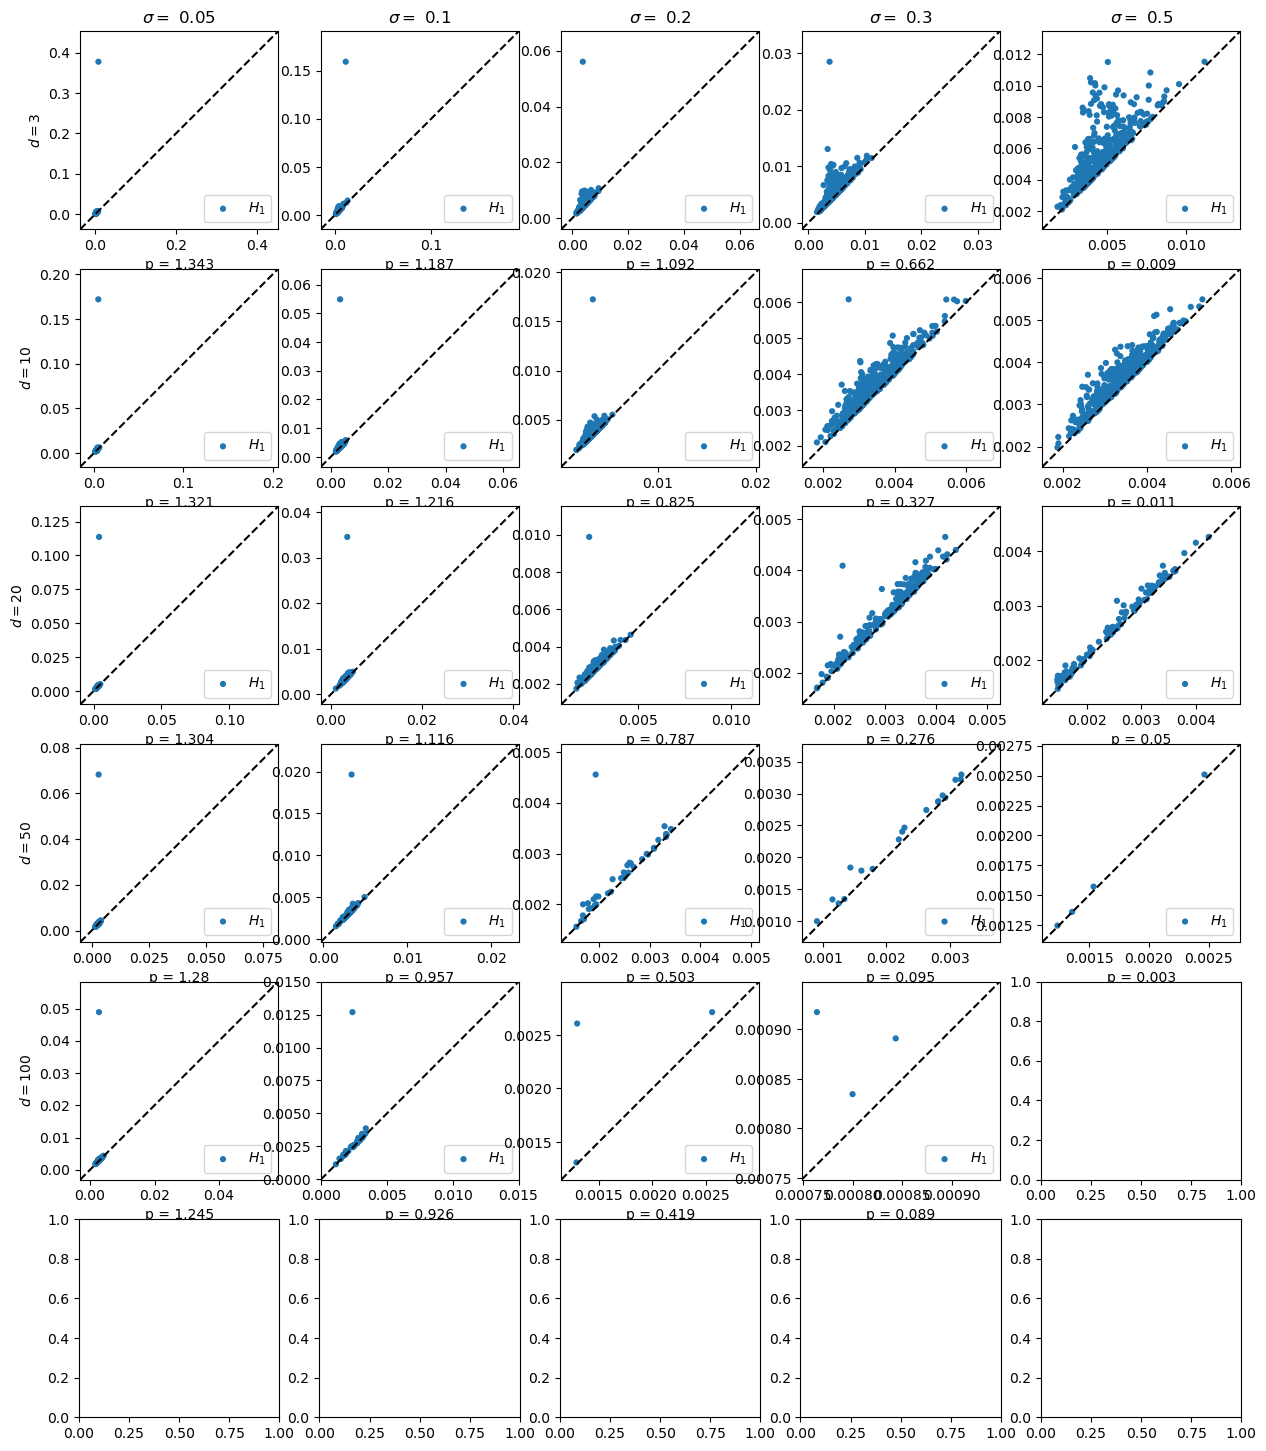

In [100]:
create_figs_ph_rwd(ds, sds, data, "eff_res", 15, 1)

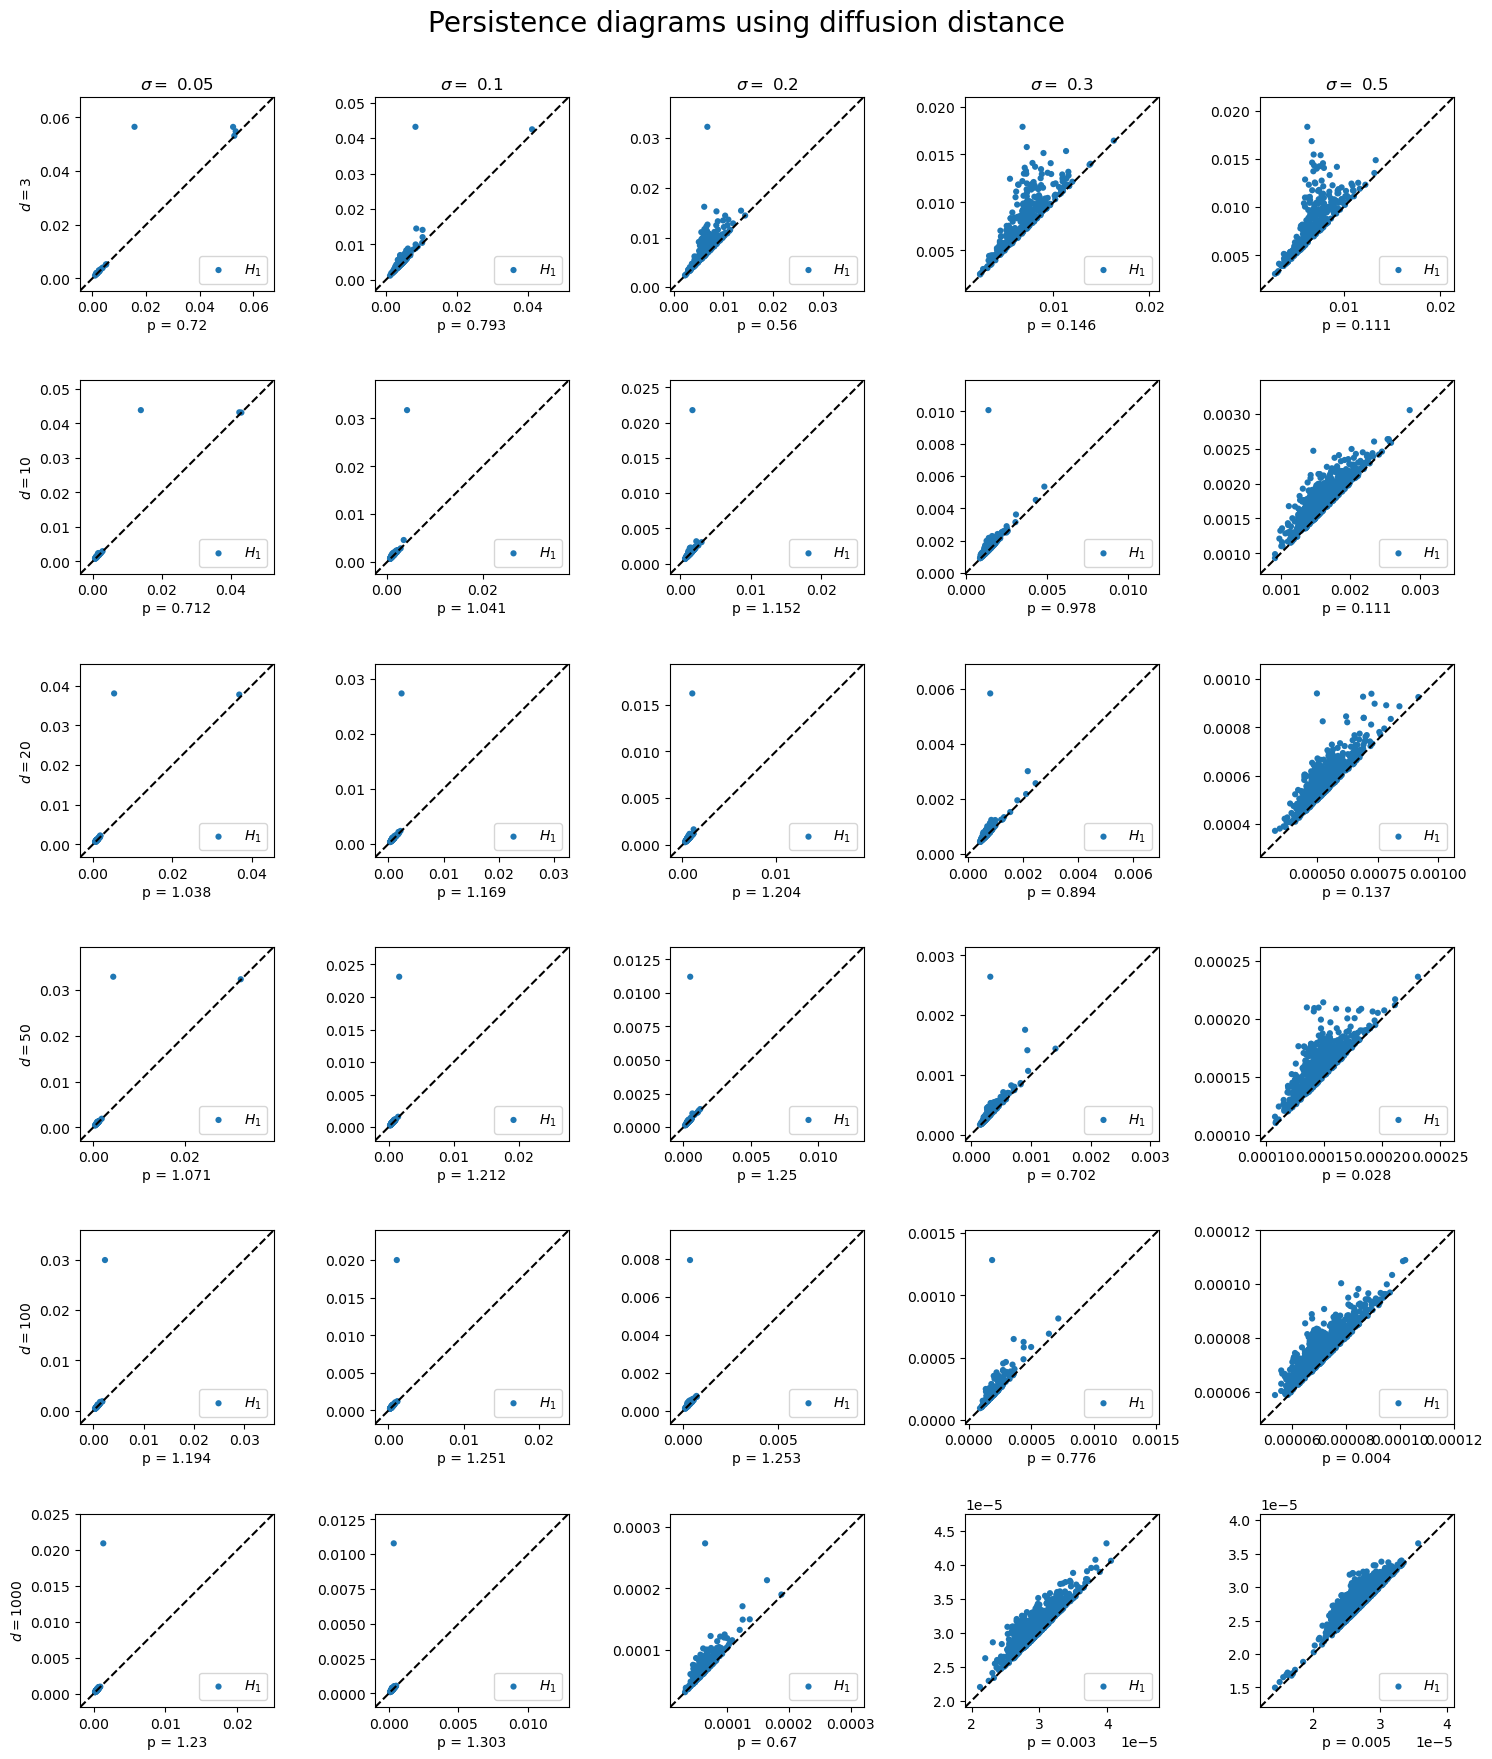

In [101]:
create_figs_ph_rwd(ds, sds, data, "diffusion", 15, 1, 8)

## Functions

In [111]:
# function that returns random matrix with orthonormal columns
def rand_orth_matrix(n, m):
    X = np.random.randn(n, m)
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    mat = u@vh
    return(mat)

# function to compute persistence score
def persistence_score(rips):
    pers_index = np.argsort(rips[1][:, 1] - rips[1][:, 0])[::-1][0:2]
    death_1 = rips[1][pers_index[0], 1]
    birth_1 = rips[1][pers_index[0], 0]
    death_2 = rips[1][pers_index[1], 1]
    birth_2 = rips[1][pers_index[1], 0]
    persistence_score = np.round( np.sqrt(2)*(death_1 - birth_1 - death_2 + birth_2)/(death_1 + birth_1) , decimals = 3)
    return persistence_score

# function to find umap hyperparameters
def umap_hyperparameter(n_neighbors, min_dist):

    res = np.zeros((len(n_neighbors)*len(min_dist), 3))
    count = 0


    for neigh in n_neighbors:
        for dist in min_dist:
            fit = umap.UMAP(n_neighbors=int(neigh), min_dist=dist)
            data_umap = fit.fit_transform(noised_data)

            diagrams_umap = ripser(data_umap)['dgms']
            pers_score = persistence_score(diagrams_umap)

            res[count, 0] = neigh
            res[count, 1] = dist
            res[count, 2] = pers_score

            count = count + 1

    index = np.argmax(res[:, 2])
    return res[index, 0], res[index, 1], res[index, 2]


# compute distance matrix of effective resistance distance
def distance_matrix_eff_r(data, k_neighbors = 10):

    knn_graph = nx.Graph(kneighbors_graph(data, k_neighbors))

    L = nx.laplacian_matrix(knn_graph).toarray() 
    L_pinv = np.linalg.pinv(L)

    n = L_pinv.shape[0]
    dist_matrix = np.zeros((n, n))

    adj = nx.adjacency_matrix(knn_graph)
    
    for i in range(n):
        for j in range(i+1, n):  
            di = knn_graph.degree(i)
            dj = knn_graph.degree(j)
            dist_matrix[i, j] = L_pinv[i, i] + L_pinv[j, j] - 2 * L_pinv[i, j] - 1/di - 1/dj + 2*adj[i,j]/(di*dj) - adj[i,i]/(di**2) - adj[j,j]/(dj**2)
            dist_matrix[j, i] = dist_matrix[i, j]  
    return dist_matrix

# compute distance matrix of diffusion distance
def distance_matrix_diffusion(data, k_neighbors=10, t=8):
    """
    param k_neighbors: number of nearest neighbors
    param t: diffusion time
    """
    # compute the graph on which we diffuse
    knn_graph = nx.to_scipy_sparse_array(nx.Graph(kneighbors_graph(data, k_neighbors)), format = 'csr')
    

    knn_graph = knn_graph + sp.eye(knn_graph.shape[0])

    # compute the diffusing transition matrix
    degrees = np.asarray(knn_graph.sum(1)).flatten()
    D_inv = sp.diags(degrees**(-1), format="csr")
    P = D_inv @ knn_graph
    P = P.toarray()

    # power it for t steps
    P_t = np.linalg.matrix_power(P, t)

    return squareform(pdist(P_t @ D_inv.toarray())) * np.sqrt(D_inv.sum())


""" 
Arguments:
ds: array of dimensions of high-dimensional space
sds: array of standard deviations of noise
data: data set without noise (dimension Nxs)
homology_dim: order of homology (0 = H_0, 1 = H_1, ...)
"""
def create_figs_ph(ds, sds, data, homology_dim):
    
    N = np.shape(data)[0]

    fig, pos = plt.subplots(len(ds), len(sds), sharex=False, sharey=False, figsize=(3*len(sds), 3*len(ds)))

    for i in range(len(ds)):
        orth_matrix = rand_orth_matrix(ds[i], np.shape(data)[1])
        for j in range(len(sds)):
            data_hd = orth_matrix @ data.T
            noise = np.random.multivariate_normal(np.repeat(0,ds[i]), sds[j]**2 * np.identity(ds[i]), N).T
            noised_data = data_hd + noise
            noised_data = noised_data.T

            ax = pos[i,j] 
            h = homology_dim

            diagrams = ripser(noised_data, maxdim = homology_dim)['dgms']
            pers_index = np.argsort(diagrams[h][:, 1] - diagrams[h][:, 0])[::-1][0:2]
            death_1 = diagrams[h][pers_index[0], 1]
            birth_1 = diagrams[h][pers_index[0], 0]
            death_2 = diagrams[h][pers_index[1], 1]
            birth_2 = diagrams[h][pers_index[1], 0]
            persistence_score = np.round( np.sqrt(2)*(death_1 - birth_1 - death_2 + birth_2)/(death_1 + birth_1) , decimals = 3) 

            plot_diagrams(diagrams, plot_only = [homology_dim], ax=ax, show=False)
            ax.set_xlabel('')  
            ax.set_ylabel('')

            ax.text(0.5, -0.2, f'p = {persistence_score}', fontsize = 10, ha='center', transform=ax.transAxes)
            
            if i == 0:
                pos[i, j].set_title(rf'$\sigma =$ {sds[j]}')
        
             # Set row title for the first column only
            if j == 0:
                pos[i, j].set_ylabel(rf'$d =${ds[i]}')


    plt.suptitle("Persistence Diagrams on noisy data", fontsize = 20)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()



"""
Arguments:
ds: array of dimensions of high-dimensional space
sds: array of standard deviations of noise
data: data set without noise (dimension Nxs)
n_comps: number of components in PCA
"""
def create_figs_pca(ds, sds, data, n_comps=2):

    N = np.shape(data)[0]

    fig, pos = plt.subplots(len(ds), len(sds), sharex=False, sharey=False, figsize=(3*len(sds), 3*len(ds)))

    for i in range(len(ds)):
        orth_matrix = rand_orth_matrix(ds[i], np.shape(data)[1])
        for j in range(len(sds)):
            data_hd = orth_matrix @ data.T
            noise = np.random.multivariate_normal(np.repeat(0,ds[i]), sds[j]**2 * np.identity(ds[i]), N).T
            noised_data = data_hd + noise
            noised_data = noised_data.T

            pca = PCA(n_components=n_comps)
            data_pca = pca.fit_transform(noised_data)

            pos[i, j].scatter(data_pca[:, 0], data_pca[:, 1], s = 5)
            
            if i == 0:
                pos[i, j].set_title(rf'$\sigma =$ {sds[j]}')
        
             # Set row title for the first column only
            if j == 0:
                pos[i, j].set_ylabel(rf'$d =${ds[i]}')


    plt.suptitle("PCA", fontsize = 20)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

                        



""" 
Arguments:
ds: array of dimensions of high-dimensional space
sds: array of standard deviations of noise
data: data set without noise (dimension Nxs)
n_comps: number of components for PCA
homology_dim: order of homology (0 = H_0, 1 = H_1, ...)
"""
def create_figs_ph_pca(ds, sds, data, n_comps, homology_dim):

    N = np.shape(data)[0]
    
    fig, pos = plt.subplots(len(ds), len(sds), sharex=False, sharey=False, figsize=(3*len(sds), 3*len(ds)))

    for i in range(len(ds)):
        orth_matrix = rand_orth_matrix(ds[i], np.shape(data)[1])
        for j in range(len(sds)):
            data_hd = orth_matrix @ data.T
            noise = np.random.multivariate_normal(np.repeat(0,ds[i]), sds[j]**2 * np.identity(ds[i]), N).T
            noised_data = data_hd + noise
            noised_data = noised_data.T

            pca = PCA(n_components=n_comps)
            data_pca = pca.fit_transform(noised_data)

            ax = pos[i,j] 
            h = homology_dim

            diagrams = ripser(data_pca, maxdim = h)['dgms']
            pers_index = np.argsort(diagrams[h][:, 1] - diagrams[h][:, 0])[::-1][0:2]
            death_1 = diagrams[h][pers_index[0], 1]
            birth_1 = diagrams[h][pers_index[0], 0]
            death_2 = diagrams[h][pers_index[1], 1]
            birth_2 = diagrams[h][pers_index[1], 0]
            persistence_score = np.round( np.sqrt(2)*(death_1 - birth_1 - death_2 + birth_2)/(death_1 + birth_1) , decimals = 3) 

            plot_diagrams(diagrams, plot_only = [h], ax=ax, show=False)
            ax.set_xlabel('')  
            ax.set_ylabel('')

            ax.text(0.5, -0.2, f'p = {persistence_score}', fontsize = 10, ha='center', transform=ax.transAxes)

            
            if i == 0:
                pos[i, j].set_title(rf'$\sigma =$ {sds[j]}')
        
             # Set row title for the first column only
            if j == 0:
                pos[i, j].set_ylabel(rf'$d =${ds[i]}')


    plt.suptitle("Persistence diagrams on PCA Data", fontsize = 20)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

                        


""" 
Arguments:
ds: array of dimensions of high-dimensional space
sds: array of standard deviations of noise
data: data set without noise (dimension Nxs)
n_neighbors: parameter for UMAP
min_distance: parameter for UMAP
"""
def create_figs_umap(ds, sds, data, n_neighbors, min_distance):

    N = np.shape(data)[0]
    
    fig, pos = plt.subplots(len(ds), len(sds), sharex=False, sharey=False, figsize=(3*len(sds), 3*len(ds)))

    for i in range(len(ds)):
        orth_matrix = rand_orth_matrix(ds[i], np.shape(data)[1])
        for j in range(len(sds)):
            data_hd = orth_matrix @ data.T
            noise = np.random.multivariate_normal(np.repeat(0,ds[i]), sds[j]**2 * np.identity(ds[i]), N).T
            noised_data = data_hd + noise
            noised_data = noised_data.T

            fit = umap.UMAP(n_neighbors = n_neighbors, min_dist = min_distance)
            data_umap = fit.fit_transform(noised_data)

            pos[i, j].scatter(data_umap[:, 0], data_umap[:, 1], s = 5)
            
            if i == 0:
                pos[i, j].set_title(rf'$\sigma =$ {sds[j]}')
        
             # Set row title for the first column only
            if j == 0:
                pos[i, j].set_ylabel(rf'$d =${ds[i]}')


    plt.suptitle("UMAP", fontsize = 20)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

                        

""" 
Arguments:
ds: array of dimensions of high-dimensional space
sds: array of standard deviations of noise
data: data set without noise (dimension Nxs)
n_neighbors: umap parameter
min_distance: umap parameter
homology_dim: order of homology (0 = H_0, 1 = H_1, ...)
"""
def create_figs_ph_umap(ds, sds, data, n_neighbors, min_distance, homology_dim):

    N = np.shape(data)[0]
    
    fig, pos = plt.subplots(len(ds), len(sds), sharex=False, sharey=False, figsize=(3*len(sds), 3*len(ds)))

    for i in range(len(ds)):
        orth_matrix = rand_orth_matrix(ds[i], np.shape(data)[1])
        for j in range(len(sds)):
            data_hd = orth_matrix @ data.T
            noise = np.random.multivariate_normal(np.repeat(0,ds[i]), sds[j]**2 * np.identity(ds[i]), N).T
            noised_data = data_hd + noise
            noised_data = noised_data.T

            fit = umap.UMAP(n_neighbors = n_neighbors, min_dist = min_distance)
            data_umap = fit.fit_transform(noised_data)

            ax = pos[i,j] 
            h = homology_dim

            diagrams = ripser(data_umap, maxdim = h)['dgms']
            pers_index = np.argsort(diagrams[h][:, 1] - diagrams[h][:, 0])[::-1][0:2]
            death_1 = diagrams[h][pers_index[0], 1]
            birth_1 = diagrams[h][pers_index[0], 0]
            death_2 = diagrams[h][pers_index[1], 1]
            birth_2 = diagrams[h][pers_index[1], 0]
            persistence_score = np.round( np.sqrt(2)*(death_1 - birth_1 - death_2 + birth_2)/(death_1 + birth_1) , decimals = 3) 

            plot_diagrams(diagrams, plot_only = [h], ax=ax, show=False)
            ax.set_xlabel('')  
            ax.set_ylabel('')

            ax.text(0.5, -0.2, f'p = {persistence_score}', fontsize = 10, ha='center', transform=ax.transAxes)

            
            if i == 0:
                pos[i, j].set_title(rf'$\sigma =$ {sds[j]}')
        
             # Set row title for the first column only
            if j == 0:
                pos[i, j].set_ylabel(rf'$d =${ds[i]}')


    plt.suptitle("Persistence diagrams on UMAP Data", fontsize = 20)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()





"""
Arguments:
ds: array of dimensions of high-dimensional space
sds: array of standard deviations of noise
data: data set without noise (dimension Nxs)
distance: distance (implemented arguments up to now: "eff_res" or "diffusion")
k_neighbors: hyperparameter for both distances
t: hyperparameter for diffusion distance
"""
def create_figs_rwd(ds, sds, data, distance, k_neighbors, t=8):

    N = np.shape(data)[0]
    
    fig, pos = plt.subplots(len(ds), len(sds), sharex=False, sharey=False, figsize=(3*len(sds), 3*len(ds)))

    for i in range(len(ds)):
        orth_matrix = rand_orth_matrix(ds[i], np.shape(data)[1])
        for j in range(len(sds)):
            data_hd = orth_matrix @ data.T
            noise = np.random.multivariate_normal(np.repeat(0,ds[i]), sds[j]**2 * np.identity(ds[i]), N).T
            noised_data = data_hd + noise
            noised_data = noised_data.T

            if distance == "eff_res":
                dist = "effective resistance distance"
                dist_mat = distance_matrix_eff_r(noised_data, k_neighbors)

            elif distance == "diffusion":
                dist = "diffusion distance"
                dist_mat = distance_matrix_diffusion(noised_data, k_neighbors, t) 

            mds = MDS(n_components = 2, dissimilarity='precomputed')
            data_mds = mds.fit_transform(dist_mat)

            pos[i, j].scatter(data_mds[:, 0], data_mds[:, 1], s = 5)
            
            if i == 0:
                pos[i, j].set_title(rf'$\sigma =$ {sds[j]}')
        
             # Set row title for the first column only
            if j == 0:
                pos[i, j].set_ylabel(rf'$d =${ds[i]}')


    plt.suptitle(f'MDS of {dist}', fontsize = 20)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()  



    """
Arguments:
ds: array of dimensions of high-dimensional space
sds: array of standard deviations of noise
data: data set without noise (dimension Nxs)
distance: distance (implemented arguments up to now: "eff_res" or "diffusion")
k_neighbors: hyperparameter for both distances
t: hyperparameter for diffusion distance
homology_dim: dimension of homology (0 = H_0, 1 = H_1, ...)
"""
def create_figs_ph_rwd(ds, sds, data, distance, k_neighbors, homology_dim, t=8):

    N = np.shape(data)[0]
    
    fig, pos = plt.subplots(len(ds), len(sds), sharex=False, sharey=False, figsize=(3*len(sds), 3*len(ds)))

    for i in range(len(ds)):
        orth_matrix = rand_orth_matrix(ds[i], np.shape(data)[1])
        for j in range(len(sds)):
            data_hd = orth_matrix @ data.T
            noise = np.random.multivariate_normal(np.repeat(0,ds[i]), sds[j]**2 * np.identity(ds[i]), N).T
            noised_data = data_hd + noise
            noised_data = noised_data.T

            if distance=="eff_res":
                dist_mat = distance_matrix_eff_r(noised_data, k_neighbors)
                dist = "effective resistance"

            if distance == "diffusion":
                dist_mat = distance_matrix_diffusion(noised_data, k_neighbors, t)
                dist = "diffusion distance"


            ax = pos[i,j] 
            h = homology_dim

            diagrams = ripser(dist_mat, maxdim = h, distance_matrix = True)['dgms']
            pers_index = np.argsort(diagrams[h][:, 1] - diagrams[h][:, 0])[::-1][0:2]
            death_1 = diagrams[h][pers_index[0], 1]
            birth_1 = diagrams[h][pers_index[0], 0]
            death_2 = diagrams[h][pers_index[1], 1]
            birth_2 = diagrams[h][pers_index[1], 0]
            persistence_score = np.round( np.sqrt(2)*(death_1 - birth_1 - death_2 + birth_2)/(death_1 + birth_1) , decimals = 3) 

            plot_diagrams(diagrams, plot_only = [h], ax=ax, show=False)
            ax.set_xlabel('')  
            ax.set_ylabel('')

            ax.text(0.5, -0.2, f'p = {persistence_score}', fontsize = 10, ha='center', transform=ax.transAxes)
            
            if i == 0:
                pos[i, j].set_title(rf'$\sigma =$ {sds[j]}')
        
             # Set row title for the first column only
            if j == 0:
                pos[i, j].set_ylabel(rf'$d =${ds[i]}')


    plt.suptitle(f"Persistence diagrams using {dist}", fontsize = 20)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

                        
           